In [ ]:
# https://github.com/loalmi/llm-resource-allocation.git

In [64]:
!git config --global user.name "@loalm"
!git config --global user.email "loalmi35@gmail.com"

In [65]:
!git clone https://github.com/loalmi/llm-resource-allocation.git

Cloning into 'llm-resource-allocation'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), done.


In [74]:
!ls

bin	 datalab  home	  lib32   media  proc		    root  srv  tools
boot	 dev	  kaggle  lib64   mnt	 python-apt	    run   sys  usr
content  etc	  lib	  libx32  opt	 python-apt.tar.xz  sbin  tmp  var


In [89]:
%cd content

/content


In [90]:
!ls

llm-resource-allocation		      openrouter_test_20260121_221140.json
openrouter_test_20260121_212158.json  openrouter_test_20260121_221951.json
openrouter_test_20260121_214138.json  results_GAIA_123.json
openrouter_test_20260121_214902.json  sample_data


In [91]:
%cd llm-resource-allocation

/content/llm-resource-allocation


In [95]:
# !rm -rf llm-resource-allocation

In [124]:
!ls

experiments  llm-resource-allocation_  README.md


In [125]:
!cp "/content/drive/MyDrive/МАГА 1 курс/НИР/llm-resource-allocation_.ipynb" .

In [126]:
!ls

experiments		  llm-resource-allocation_.ipynb
llm-resource-allocation_  README.md


In [146]:
!git add llm-resource-allocation_.ipynb

In [147]:
!git commit -m "Добавлен текущий ноутбук из Colab"

On branch main
Your branch and 'origin/main' have diverged,
and have 1 and 1 different commits each, respectively.
  (use "git pull" to merge the remote branch into yours)

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	llm-resource-allocation_

nothing added to commit but untracked files present (use "git add" to track)


In [144]:
!git reset HEAD~1

In [138]:
!git push origin main

Everything up-to-date


In [145]:
!git add llm-resource-allocation_.ipynb
!git commit -m "Добавлен ноутбук без токена"
!git push origin main

[main c9cd963] Добавлен ноутбук без токена
 1 file changed, 1 insertion(+)
 create mode 100644 llm-resource-allocation_.ipynb
To https://github.com/loalmi/llm-resource-allocation.git
 ! [rejected]        main -> main (non-fast-forward)
error: failed to push some refs to 'https://github.com/loalmi/llm-resource-allocation.git'
hint: Updates were rejected because the tip of your current branch is behind
hint: its remote counterpart. Integrate the remote changes (e.g.
hint: 'git pull ...') before pushing again.
hint: See the 'Note about fast-forwards' in 'git push --help' for details.


In [2]:
"""
Мультиагентная система для решения задач GAIA с game-theoretic распределением ресурсов
Архитектура: GAIA задача → Декомпозитор → Подзадачи → Оракул → Роутер → Агенты
"""

'\nМультиагентная система для решения задач GAIA с game-theoretic распределением ресурсов\nАрхитектура: GAIA задача → Декомпозитор → Подзадачи → Оракул → Роутер → Агенты\n'

In [51]:
import numpy as np
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
import json
from enum import Enum

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install ortools

Структура данных:

    - Subtask: Подзадача с типом и порядковым номером
    - Agent: Агент с ролью и инструментами
    - ModelPackage: Модель + токены равной стоимости
    - Allocation: Распределение (подзадача → агент → модель)

Основные компоненты:

    - TaskDecomposer: Анализирует колонку GAIA, классифицирует типы подзадач
    - UtilityOracle: Генерирует 3D матрицу полезностей
    - GameTheoreticRouter: Распределяет с учетом fairness критериев
    - BaseAgent: Исполняет подзадачи с поддержкой контекста

**Модели данных**

In [52]:
class TaskType(Enum):
    RESEARCH = "research"
    ANALYSIS = "analysis"
    CODING = "coding"
    REASONING = "reasoning"
    SUMMARIZATION = "summarization"

class AgentRole(Enum):
    RESEARCHER = "researcher"
    ANALYST = "analyst"
    PROGRAMMER = "programmer"
    REASONER = "reasoner"
    WRITER = "writer"

class LLMModel(Enum):
    GPT4 = "gpt-4"
    CLAUDE3 = "claude-3"
    LLAMA3 = "llama-3"
    GEMMA = "gemma"
    MIXTRAL = "mixtral"

@dataclass
class Subtask:
    """Подзадача после декомпозиции"""
    id: str
    description: str
    task_type: TaskType
    parent_task_id: str
    step_number: int

@dataclass
class Agent:
    """Агент с ролью и конфигурацией"""
    id: str
    role: AgentRole
    tools: List[str]  # Инструменты агента
    memory_size: int = 1000

@dataclass
class ModelPackage:
    """Пакет: модель + количество токенов (равной стоимости)"""
    model: LLMModel
    token_budget: int
    cost: float  # Все пакеты имеют одинаковую стоимость

@dataclass
class Allocation:
    """Распределение подзадачи агенту с моделью"""
    subtask: Subtask
    agent: Agent
    model_package: ModelPackage
    predicted_utility: float


**Декомпозитор**

In [53]:
class TaskDecomposer:
    """Разбивает задачи GAIA на последовательные подзадачи"""

    def __init__(self):
        self.cache = {}  # Кэш декомпозиций

    def decompose_gaia_task(self, task_id: str, task_description: str,
                          subtasks_column: List[str]) -> List[Subtask]:
        """
        Преобразует колонку с подзадачами из GAIA в структурированные Subtask объекты

        Args:
            task_id: ID задачи из GAIA
            task_description: Описание основной задачи
            subtasks_column: Список шагов из колонки GAIA (аннотированные человеком)

        Returns:
            Список подзадач с типами и порядковыми номерами
        """
        if task_id in self.cache:
            return self.cache[task_id]

        subtasks = []
        for i, step in enumerate(subtasks_column, 1):
            # Определяем тип задачи на основе содержимого
            task_type = self._classify_subtask(step)

            subtask = Subtask(
                id=f"{task_id}_step_{i}",
                description=step,
                task_type=task_type,
                parent_task_id=task_id,
                step_number=i
            )
            subtasks.append(subtask)

        self.cache[task_id] = subtasks
        return subtasks

    def _classify_subtask(self, step_description: str) -> TaskType:
        """Классифицирует тип подзадачи по описанию"""
        step_lower = step_description.lower()

        if any(word in step_lower for word in ["find", "search", "look up", "gather"]):
            return TaskType.RESEARCH
        elif any(word in step_lower for word in ["analyze", "compare", "calculate", "evaluate"]):
            return TaskType.ANALYSIS
        elif any(word in step_lower for word in ["code", "program", "implement", "function"]):
            return TaskType.CODING
        elif any(word in step_lower for word in ["reason", "deduce", "infer", "if-then"]):
            return TaskType.REASONING
        elif any(word in step_lower for word in ["summarize", "conclude", "write", "report"]):
            return TaskType.SUMMARIZATION
        else:
            return TaskType.ANALYSIS  # По умолчанию

**Оракул (генерация кубика полезности)**

In [54]:
class UtilityOracle:
    """Генерирует кубик оценок U[subtask][agent][model]"""

    def __init__(self, temperature: float = 0.1):
        self.temperature = temperature
        self.utility_cubes = {}  # Кэш кубиков по task_id

    def generate_utility_cube(self, subtasks: List[Subtask],
                            agents: List[Agent],
                            model_packages: List[ModelPackage]) -> np.ndarray:
        """
        Генерирует 3D матрицу полезностей U[subtask][agent][model]

        Returns:
            numpy array shape (n_subtasks, n_agents, n_models)
        """
        task_id = subtasks[0].parent_task_id if subtasks else "unknown"

        if task_id in self.utility_cubes:
            return self.utility_cubes[task_id]

        n_subtasks = len(subtasks)
        n_agents = len(agents)
        n_models = len(model_packages)

        utility_cube = np.zeros((n_subtasks, n_agents, n_models))

        # Генерация оценок (пока заглушка - в реальности через LLM)
        for i, subtask in enumerate(subtasks):
            for j, agent in enumerate(agents):
                for k, model_pkg in enumerate(model_packages):
                    utility_cube[i, j, k] = self._estimate_utility(
                        subtask, agent, model_pkg
                    )

        self.utility_cubes[task_id] = utility_cube
        return utility_cube

    def _estimate_utility(self, subtask: Subtask, agent: Agent,
                         model_pkg: ModelPackage) -> float:
        """
        Оценивает полезность комбинации (заглушка - будет заменена на LLM вызов)

        В реальности:
        1. Формируем промпт: "Насколько хорошо {agent.role} с {model}
           решит задачу: {subtask.description}? Оцени 0-1"
        2. Вызываем LLM
        3. Парсим ответ
        """
        # Базовая эвристика
        base_score = 0.5

        # Корректировка по специализации агента
        role_fit = self._get_role_fit_score(subtask.task_type, agent.role)
        base_score *= role_fit

        # Корректировка по модели
        model_fit = self._get_model_fit_score(subtask.task_type, model_pkg.model)
        base_score *= model_fit

        # Добавляем небольшой шум
        noise = np.random.normal(0, 0.1 * self.temperature)
        return np.clip(base_score + noise, 0.0, 1.0)

    def _get_role_fit_score(self, task_type: TaskType, agent_role: AgentRole) -> float:
        """Сколько агент подходит для типа задачи"""
        fit_matrix = {
            TaskType.RESEARCH: {
                AgentRole.RESEARCHER: 0.9,
                AgentRole.ANALYST: 0.7,
                AgentRole.REASONER: 0.6,
                AgentRole.PROGRAMMER: 0.3,
                AgentRole.WRITER: 0.4,
            },
            TaskType.ANALYSIS: {
                AgentRole.RESEARCHER: 0.6,
                AgentRole.ANALYST: 0.9,
                AgentRole.REASONER: 0.8,
                AgentRole.PROGRAMMER: 0.5,
                AgentRole.WRITER: 0.4,
            },
            # ... аналогично для других типов
        }
        return fit_matrix.get(task_type, {}).get(agent_role, 0.5)

    def _get_model_fit_score(self, task_type: TaskType, model: LLMModel) -> float:
        """Насколько модель подходит для типа задачи"""
        # Упрощенная матрица
        return 0.8  # Заглушка

**Роутер (распределение моделей по агентам)**

In [55]:
class GameTheoreticRouter:
    """Распределяет подзадачи по агентам на основе кубика оценок"""

    def __init__(self, fairness_criterion: str = "NSW"):
        """
        Args:
            fairness_criterion: "NSW" (Nash), "USW" (Utilitarian), "EF" (Envy-Free)
        """
        self.fairness_criterion = fairness_criterion

    def allocate_tasks(self, subtasks: List[Subtask],
                      agents: List[Agent],
                      model_packages: List[ModelPackage],
                      utility_cube: np.ndarray) -> List[Allocation]:
        """
        Распределяет подзадачи с учетом последовательности выполнения

        Особенность: Каждая следующая подзадача получает результаты предыдущей
        """
        n_subtasks = len(subtasks)
        n_agents = len(agents)

        allocations = []
        previous_results = None

        for step in range(n_subtasks):
            # Для последовательных задач учитываем предыдущие результаты
            context_aware_utility = self._adjust_utilities_for_context(
                utility_cube[step], previous_results, step
            )

            # Выбираем оптимальное распределение для текущего шага
            allocation = self._allocate_single_step(
                subtasks[step], agents, model_packages, context_aware_utility, step
            )

            allocations.append(allocation)

            # Обновляем контекст для следующего шага
            previous_results = {
                'step': step,
                'agent': allocation.agent,
                'model': allocation.model_package.model,
                'subtask_type': subtasks[step].task_type
            }

        return allocations

    def _allocate_single_step(self, subtask: Subtask,
                            agents: List[Agent],
                            model_packages: List[ModelPackage],
                            utilities_2d: np.ndarray,  # [agent][model]
                            step_number: int) -> Allocation:
        """Распределяет одну подзадачу"""

        if self.fairness_criterion == "USW":
            # Утилитарный подход: максимизация суммы
            best_agent_idx, best_model_idx = np.unravel_index(
                np.argmax(utilities_2d), utilities_2d.shape
            )

        elif self.fairness_criterion == "NSW":
            # Nash Social Welfare (баланс efficiency/fairness)
            # Пока упрощенная версия
            best_agent_idx, best_model_idx = self._nash_allocation(utilities_2d, step_number)

        elif self.fairness_criterion == "EF":
            # Envy-Free распределение
            best_agent_idx, best_model_idx = self._envy_free_allocation(utilities_2d, step_number)

        else:
            raise ValueError(f"Unknown fairness criterion: {self.fairness_criterion}")

        return Allocation(
            subtask=subtask,
            agent=agents[best_agent_idx],
            model_package=model_packages[best_model_idx],
            predicted_utility=utilities_2d[best_agent_idx, best_model_idx]
        )

    def _adjust_utilities_for_context(self, utilities_2d: np.ndarray,
                                    previous_results: Optional[Dict],
                                    current_step: int) -> np.ndarray:
        """Корректирует полезности с учетом контекста (результатов предыдущих шагов)"""
        adjusted = utilities_2d.copy()

        if previous_results is not None:
            # Пример эвристики: агент, который уже работал, может быть более эффективен
            # на связанных задачах
            # В реальности это будет определяться через LLM анализ связанности задач
            pass

        return adjusted

    def _nash_allocation(self, utilities_2d: np.ndarray, step: int) -> Tuple[int, int]:
        """Упрощенная версия NSW распределения"""
        # Пока используем жадный подход с учетом предыдущих назначений
        # В полной версии будем оптимизировать произведение полезностей
        return np.unravel_index(np.argmax(utilities_2d), utilities_2d.shape)

    def _envy_free_allocation(self, utilities_2d: np.ndarray, step: int) -> Tuple[int, int]:
        """Упрощенная версия EF распределения"""
        # Пока аналогично NSW
        return np.unravel_index(np.argmax(utilities_2d), utilities_2d.shape)


**Агенты (исполнители)**

In [56]:
class BaseAgent:
    """Базовый класс агента"""

    def __init__(self, agent_id: str, role: AgentRole):
        self.id = agent_id
        self.role = role
        self.memory = []

    def execute(self, subtask: Subtask, model_package: ModelPackage,
                context: Optional[str] = None) -> str:
        """
        Выполняет подзадачу с заданной моделью

        Args:
            subtask: Подзадача для выполнения
            model_package: Модель и бюджет токенов
            context: Результаты предыдущих шагов (для последовательных задач)

        Returns:
            Результат выполнения
        """
        # Формируем промпт с учетом контекста
        prompt = self._build_prompt(subtask, context)

        # Вызываем LLM (заглушка)
        result = self._call_llm(prompt, model_package)

        # Сохраняем в память
        self.memory.append({
            'subtask': subtask.id,
            'prompt': prompt[:100],  # Сохраняем начало для отладки
            'result': result[:500],  # Сохраняем начало результата
            'model': model_package.model.value
        })

        return result

    def _build_prompt(self, subtask: Subtask, context: Optional[str]) -> str:
        """Формирует промпт для LLM"""
        prompt = f"""
        Ты {self.role.value} в мультиагентной системе.

        Задача: {subtask.description}
        """

        if context:
            prompt += f"\nКонтекст (результаты предыдущих шагов):\n{context}"

        prompt += f"\n\nВыполни эту задачу шаг за шагом. Будь точным и детальным."

        return prompt

    def _call_llm(self, prompt: str, model_package: ModelPackage) -> str:
        """Заглушка для вызова LLM"""
        # В реальности: вызов API соответствующей модели
        return f"Результат выполнения задачи с моделью {model_package.model.value}"


**Главная система - координация остальных компонент (архитектура, которая описывалась первоначально)**

In [57]:
class MultiAgentSystem:
    """Основная система, координирующая все компоненты"""

    def __init__(self):
        self.decomposer = TaskDecomposer()
        self.oracle = UtilityOracle()
        self.router = GameTheoreticRouter(fairness_criterion="NSW")
        self.agents = self._initialize_agents()
        self.model_packages = self._initialize_model_packages()

    def _initialize_agents(self) -> List[Agent]:
        """Инициализирует агентов с разными ролями"""
        return [
            Agent(id="agent_1", role=AgentRole.RESEARCHER, tools=["web_search", "data_collection"]),
            Agent(id="agent_2", role=AgentRole.ANALYST, tools=["statistics", "data_analysis"]),
            Agent(id="agent_3", role=AgentRole.PROGRAMMER, tools=["code_generation", "debugging"]),
            Agent(id="agent_4", role=AgentRole.REASONER, tools=["logical_reasoning", "inference"]),
            Agent(id="agent_5", role=AgentRole.WRITER, tools=["summarization", "report_writing"]),
        ]

    def _initialize_model_packages(self) -> List[ModelPackage]:
        """Создает пакеты моделей с токенами равной стоимости"""
        # Все пакеты имеют одинаковую стоимость (например, $0.10)
        base_cost = 0.10

        return [
            ModelPackage(model=LLMModel.GPT4, token_budget=1000, cost=base_cost),
            ModelPackage(model=LLMModel.CLAUDE3, token_budget=1500, cost=base_cost),
            ModelPackage(model=LLMModel.LLAMA3, token_budget=3000, cost=base_cost),
            ModelPackage(model=LLMModel.GEMMA, token_budget=3500, cost=base_cost),
            ModelPackage(model=LLMModel.MIXTRAL, token_budget=2500, cost=base_cost),
        ]

    def solve_gaia_task(self, task_id: str, task_description: str,
                       gaia_subtasks: List[str]) -> Dict:
        """
        Основной пайплайн решения задачи GAIA

        Args:
            task_id: ID задачи из GAIA
            task_description: Описание задачи
            gaia_subtasks: Список подзадач из колонки GAIA

        Returns:
            Результаты выполнения
        """
        print(f"Начинаем решение задачи {task_id}")

        print("1. Декомпозиция задачи...")
        subtasks = self.decomposer.decompose_gaia_task(
            task_id, task_description, gaia_subtasks
        )
        print(f"   Получено {len(subtasks)} подзадач")

        print("2. Генерация кубика оценок...")
        utility_cube = self.oracle.generate_utility_cube(
            subtasks, self.agents, self.model_packages
        )
        print(f"   Размер кубика: {utility_cube.shape}")

        print("3. Распределение подзадач (роутинг)...")
        allocations = self.router.allocate_tasks(
            subtasks, self.agents, self.model_packages, utility_cube
        )

        print("4. Последовательное выполнение подзадач...")
        results = []
        previous_result = None

        for i, allocation in enumerate(allocations):
            print(f"   Шаг {i+1}: {allocation.agent.role.value} → {allocation.model_package.model.value}")

            # Создаем экземпляр агента
            agent_instance = BaseAgent(allocation.agent.id, allocation.agent.role)

            # Выполняем с учетом предыдущих результатов
            result = agent_instance.execute(
                allocation.subtask,
                allocation.model_package,
                context=previous_result
            )

            results.append({
                'step': i + 1,
                'subtask': allocation.subtask.description,
                'agent': allocation.agent.role.value,
                'model': allocation.model_package.model.value,
                'predicted_utility': allocation.predicted_utility,
                'result': result[:200]  # Сохраняем начало
            })

            # Обновляем контекст для следующего шага
            previous_result = result

        # 5. Агрегация результатов
        print("5. Агрегация финального ответа...")
        final_answer = self._aggregate_results(results)

        return {
            'task_id': task_id,
            'allocations': [
                {
                    'step': r['step'],
                    'agent': r['agent'],
                    'model': r['model'],
                    'utility': r['predicted_utility']
                } for r in results
            ],
            'final_answer': final_answer,
            'utility_cube_stats': {
                'mean': float(np.mean(utility_cube)),
                'std': float(np.std(utility_cube)),
                'max': float(np.max(utility_cube)),
                'min': float(np.min(utility_cube))
            }
        }

    def _aggregate_results(self, results: List[Dict]) -> str:
        """Агрегирует результаты всех шагов в финальный ответ"""
        # В реальности может быть отдельный агент-агрегатор
        aggregated = "Финальный ответ на задачу:\n\n"
        for r in results:
            aggregated += f"Шаг {r['step']} ({r['agent']}): {r['result']}\n\n"
        return aggregated

**Пример использования**

In [20]:
def main():
    """Пример использования системы с тестовой задачей GAIA"""

    # Создаем систему
    mas = MultiAgentSystem()

    # Тестовая задача GAIA (пример)
    task_id = "GAIA_123"
    task_description = "Проанализируйте влияние изменения налоговой политики на малый бизнес"

    # Подзадачи из колонки GAIA (аннотированные человеком)
    gaia_subtasks = [
        "Найти данные по налоговой нагрузке на малый бизнес за последние 5 лет",
        "Проанализировать корреляцию между изменением налогов и количеством банкротств",
        "Рассчитать экономический эффект от предлагаемых изменений",
        "Сформулировать выводы и рекомендации для правительства"
    ]

    # Запускаем систему
    try:
        result = mas.solve_gaia_task(task_id, task_description, gaia_subtasks)

        # Выводим результаты
        print("\n" + "="*60)
        print("РЕЗУЛЬТАТЫ ВЫПОЛНЕНИЯ")

        print(f"\nЗадача: {task_id}")
        print(f"Распределение подзадач:")
        for alloc in result['allocations']:
            print(f"  Шаг {alloc['step']}: {alloc['agent']} + {alloc['model']} (utility: {alloc['utility']:.2f})")

        print(f"\nСтатистика кубика оценок:")
        stats = result['utility_cube_stats']
        print(f"  Среднее: {stats['mean']:.3f}, Std: {stats['std']:.3f}")
        print(f"  Min: {stats['min']:.3f}, Max: {stats['max']:.3f}")

        print(f"\nФинальный ответ (первые 500 символов):")
        print(result['final_answer'][:500] + "...")

        # Сохраняем результаты
        with open(f"results_{task_id}.json", "w", encoding="utf-8") as f:
            json.dump(result, f, indent=2, ensure_ascii=False)
        print(f"\nРезультаты сохранены в results_{task_id}.json")

    except Exception as e:
        print(f"Ошибка: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Начинаем решение задачи GAIA_123
1. Декомпозиция задачи...
   Получено 4 подзадач
2. Генерация кубика оценок...
   Размер кубика: (4, 5, 5)
3. Распределение подзадач (роутинг)...
4. Последовательное выполнение подзадач...
   Шаг 1: analyst → claude-3
   Шаг 2: analyst → gemma
   Шаг 3: analyst → claude-3
   Шаг 4: analyst → gemma
5. Агрегация финального ответа...

РЕЗУЛЬТАТЫ ВЫПОЛНЕНИЯ

Задача: GAIA_123
Распределение подзадач:
  Шаг 1: analyst + claude-3 (utility: 0.37)
  Шаг 2: analyst + gemma (utility: 0.37)
  Шаг 3: analyst + claude-3 (utility: 0.37)
  Шаг 4: analyst + gemma (utility: 0.37)

Статистика кубика оценок:
  Среднее: 0.257, Std: 0.074
  Min: 0.147, Max: 0.375

Финальный ответ (первые 500 символов):
Финальный ответ на задачу:

Шаг 1 (analyst): Результат выполнения задачи с моделью claude-3

Шаг 2 (analyst): Результат выполнения задачи с моделью gemma

Шаг 3 (analyst): Результат выполнения задачи с моделью claude-3

Шаг 4 (analyst): Результат выполнения задачи с моделью gem

## **Настройка OpenRouter**

In [21]:
pip install openai python-dotenv

In [58]:
import os
import json
from typing import Dict, List, Optional, Any
from dataclasses import dataclass, asdict
from enum import Enum
import openai
from openai import OpenAI
from dotenv import load_dotenv
import numpy as np
from datetime import datetime

In [59]:
# Загружаем переменные окружения
load_dotenv()

False

**Конфигурация и базовый класс**

In [60]:
class ModelProvider(Enum):
    """Провайдеры моделей через OpenRouter"""
    OPENROUTER = "openrouter"


@dataclass
class ModelConfig:
    """Конфигурация одной модели"""
    name: str
    openrouter_id: str  # ID модели в OpenRouter
    context_window: int  # Максимальный контекст (в токенах)
    cost_per_1k_input: float  # Стоимость 1000 входных токенов ($)
    cost_per_1k_output: float  # Стоимость 1000 выходных токенов ($)
    description: str = ""  # Описание модели

    def calculate_cost(self, input_tokens: int, output_tokens: int) -> float:
        """Рассчитывает стоимость запроса"""
        input_cost = (input_tokens / 1000) * self.cost_per_1k_input
        output_cost = (output_tokens / 1000) * self.cost_per_1k_output
        return round(input_cost + output_cost, 4)

class LLMModelInstance:
    """Экземпляр модели LLM через OpenRouter"""

    def __init__(self, config: ModelConfig, api_key: Optional[str] = None):
        self.config = config
        self.api_key = api_key or os.getenv("OPENROUTER_API_KEY")

        if not self.api_key:
            raise ValueError("OpenRouter API key не найден. Установите OPENROUTER_API_KEY в .env")

        # Инициализируем клиент OpenRouter
        self.client = OpenAI(
            base_url="https://openrouter.ai/api/v1",
            api_key=self.api_key
        )

        # Статистика использования
        self.total_tokens_used = 0
        self.total_cost = 0.0
        self.request_count = 0

    def generate(self,
                 prompt: str,
                 system_prompt: Optional[str] = None,
                 max_tokens: int = 1000,
                 temperature: float = 0.7,
                 **kwargs) -> Dict[str, Any]:
        """
        Генерирует ответ через OpenRouter

        Args:
            prompt: Основной промпт
            system_prompt: Системный промпт (роль модели)
            max_tokens: Максимальное количество токенов в ответе
            temperature: Температура генерации (0-2)

        Returns:
            Словарь с ответом и метаданными
        """
        messages = []

        # Добавляем системный промпт если есть
        if system_prompt:
            messages.append({"role": "system", "content": system_prompt})

        # Добавляем пользовательский промпт
        messages.append({"role": "user", "content": prompt})

        try:
            response = self.client.chat.completions.create(
                model=self.config.openrouter_id,
                messages=messages,
                max_tokens=max_tokens,
                temperature=temperature,
                **kwargs
            )

            # Извлекаем ответ
            content = response.choices[0].message.content

            # Собираем статистику
            usage = response.usage
            input_tokens = usage.prompt_tokens
            output_tokens = usage.completion_tokens
            total_tokens = usage.total_tokens

            # Рассчитываем стоимость
            cost = self.config.calculate_cost(input_tokens, output_tokens)

            # Обновляем статистику
            self.total_tokens_used += total_tokens
            self.total_cost += cost
            self.request_count += 1

            return {
                "content": content,
                "input_tokens": input_tokens,
                "output_tokens": output_tokens,
                "total_tokens": total_tokens,
                "cost": cost,
                "model": self.config.name,
                "finish_reason": response.choices[0].finish_reason
            }

        except Exception as e:
            print(f"Ошибка при вызове {self.config.name}: {str(e)}")
            return {
                "content": f"ERROR: {str(e)}",
                "input_tokens": 0,
                "output_tokens": 0,
                "total_tokens": 0,
                "cost": 0,
                "model": self.config.name,
                "error": str(e)
            }

    def get_stats(self) -> Dict[str, Any]:
        """Возвращает статистику использования модели"""
        return {
            "model": self.config.name,
            "requests": self.request_count,
            "total_tokens": self.total_tokens_used,
            "total_cost": round(self.total_cost, 4),
            "avg_cost_per_request": round(self.total_cost / self.request_count, 4) if self.request_count > 0 else 0
        }

**Фабрика моделей**

Реальные расценки на OpenRouter

*Meta: Llama 3 70B Instruct*
- *meta-llama/llama-3-70b-instruct*

      Created Apr 18, 2024
      8,192 context
      $0.40/M input tokens
      $0.40/M output tokens
      получается :
      cost_per_1k_input=0.0004
      cost_per_1k_output=0.0004

Meta: Llama 3 8B Instruct
- meta-llama/llama-3-8b-instruct

      Created Apr 18, 2024
      8,192 context
      $0.03/M input tokens
      $0.06/M output tokens
      получается :
      cost_per_1k_input=0.00003
      cost_per_1k_output=0.00006

Anthropic: Claude 3 Haiku
- anthropic/claude-3-haiku

      Created Mar 13, 2024
      200,000 context
      $0.25/M input tokens
      $1.25/M output tokens
      получается :
      cost_per_1k_input=0.00025
      cost_per_1k_output=0.00125

OpenAI: GPT-4o-mini
- openai/gpt-4o-mini

      Created Jul 18, 2024
      128,000 context
      Starting at $0.15/M input tokens
      Starting at $0.60/M output tokens
      получается :
      cost_per_1k_input=0.00015
      cost_per_1k_output=0.0006



**Создаем три конкретные модели**

In [61]:
# Конфигурации для трех разных моделей через OpenRouter
MODEL_CONFIGS = {
    "gpt4": ModelConfig(
        name="GPT-4o-mini",
        openrouter_id="openai/gpt-4o-mini",
        context_window=8192,
        cost_per_1k_input=0.00015,   # Примерная стоимость
        cost_per_1k_output=0.0006,  # Примерная стоимость
        description="модель OpenAI, отлично подходит для сложных рассуждений"
    ),

    "claude3": ModelConfig(
        name="Claude-3 Haiku",
        openrouter_id="anthropic/claude-3-haiku",
        context_window=200000,
        cost_per_1k_input=0.00025,   # Примерная стоимость
        cost_per_1k_output=0.00125,  # Примерная стоимость
        description="Claude от Anthropic, хорош для анализа и рассуждений"
    ),

    # "llama3": ModelConfig(
    #     name="Llama-3 70B",
    #     openrouter_id="meta-llama/llama-3-70b-instruct",
    #     context_window=8192,
    #     cost_per_1k_input=0.0004,  # Примерная стоимость
    #     cost_per_1k_output=0.0004, # Примерная стоимость
    #     description="Мощная открытая модель от Meta, хорош для кодинга"
    # )

# Заменю модель, потому что предыдущ версия не всегда выдает ответ и требует специфичный ввод
      "llama3": ModelConfig(
        name="Llama-3 8B Instruct",
        openrouter_id="meta-llama/llama-3-8b-instruct",
        context_window=8192,
        cost_per_1k_input=0.00003,  # Примерная стоимость
        cost_per_1k_output=0.00006, # Примерная стоимость
        description="Мощная открытая модель от Meta, хорош для кодинга"
    )
}

class ModelFactory:
    """Фабрика для создания экземпляров моделей"""

    @staticmethod
    def create_model(model_key: str, api_key: Optional[str] = None) -> LLMModelInstance:
        """Создает экземпляр модели по ключу"""
        if model_key not in MODEL_CONFIGS:
            available = list(MODEL_CONFIGS.keys())
            raise ValueError(f"Модель {model_key} не найдена. Доступные: {available}")

        config = MODEL_CONFIGS[model_key]
        return LLMModelInstance(config, api_key)

    @staticmethod
    def create_all_models(api_key: Optional[str] = None) -> Dict[str, LLMModelInstance]:
        """Создает все три модели"""
        models = {}
        for key in MODEL_CONFIGS:
            models[key] = ModelFactory.create_model(key, api_key)
        return models

**Интеграция с системой агентов**

In [62]:
class OpenRouterAgent:
    """Агент, использующий модели через OpenRouter"""

    def __init__(self,
                 agent_id: str,
                 role: str,
                 default_model_key: str = "gpt4",
                 api_key: Optional[str] = None):

        self.agent_id = agent_id
        self.role = role
        self.api_key = api_key or os.getenv("OPENROUTER_API_KEY")

        # Создаем все три модели, которые может использовать агент
        self.models = ModelFactory.create_all_models(self.api_key)
        self.default_model = self.models[default_model_key]

        # История запросов
        self.history = []

    def execute_task(self,
                    task_description: str,
                    context: Optional[str] = None,
                    model_key: Optional[str] = None,
                    **kwargs) -> Dict[str, Any]:
        """
        Выполняет задачу с выбранной моделью

        Args:
            task_description: Описание задачи
            context: Контекст (результаты предыдущих шагов)
            model_key: Ключ модели (если None, используется default_model)

        Returns:
            Результат выполнения
        """
        # Выбираем модель
        model = self.models.get(model_key, self.default_model) if model_key else self.default_model

        # Формируем системный промпт на основе роли агента
        system_prompt = self._create_system_prompt()

        # Формируем полный промпт с контекстом
        full_prompt = self._create_full_prompt(task_description, context)

        # Вызываем модель
        start_time = datetime.now()
        result = model.generate(
            prompt=full_prompt,
            system_prompt=system_prompt,
            **kwargs
        )
        end_time = datetime.now()

        # Сохраняем в историю
        history_entry = {
            "timestamp": start_time.isoformat(),
            "agent_id": self.agent_id,
            "role": self.role,
            "model": model.config.name,
            "task": task_description,
            "context": context[:100] + "..." if context else None,
            "response": result["content"][:500] + "..." if result["content"] else "",
            "tokens": result["total_tokens"],
            "cost": result["cost"],
            "duration_ms": int((end_time - start_time).total_seconds() * 1000)
        }
        self.history.append(history_entry)

        return {
            "agent": self.agent_id,
            "role": self.role,
            "model": model.config.name,
            "response": result["content"],
            "metadata": result,
            "history_entry": history_entry
        }

    def _create_system_prompt(self) -> str:
        """Создает системный промпт на основе роли агента"""
        prompts = {
            "researcher": """Ты эксперт-исследователь в мультиагентной системе.
Твоя задача: находить и анализировать информацию. Будь точным, приводи источники когда возможно.
Отвечай подробно, но по делу.""",

            "analyst": """Ты аналитик в мультиагентной системе.
Твоя задача: анализировать данные, находить закономерности, делать выводы.
Используй логические рассуждения, проверяй свои выводы.""",

            "programmer": """Ты программист в мультиагентной системе.
Твоя задача: писать код, решать технические проблемы, объяснять алгоритмы.
Пиши чистый, документированный код с примерами.""",

            "writer": """Ты писатель/суммаризатор в мультиагентной системе.
Твоя задача: структурировать информацию, писать отчеты, делать выводы.
Будь ясным, структурированным, избегай избыточности."""
        }

        return prompts.get(self.role, "Ты полезный AI ассистент в мультиагентной системе.")

    def _create_full_prompt(self, task: str, context: Optional[str]) -> str:
        """Создает полный промпт с контекстом"""
        if context:
            return f"""Контекст (результаты предыдущих шагов):
{context}

Текущая задача:
{task}

Выполни задачу, учитывая контекст выше."""
        else:
            return task

    def get_agent_stats(self) -> Dict[str, Any]:
        """Статистика использования агента"""
        total_cost = sum(entry.get("cost", 0) for entry in self.history)
        total_tokens = sum(entry.get("tokens", 0) for entry in self.history)

        # Статистика по моделям
        model_stats = {}
        for model_instance in self.models.values():
            model_stats[model_instance.config.name] = model_instance.get_stats()

        return {
            "agent_id": self.agent_id,
            "role": self.role,
            "total_requests": len(self.history),
            "total_tokens": total_tokens,
            "total_cost": round(total_cost, 4),
            "model_stats": model_stats
        }

**Демонстрация работы системы**

In [44]:
def demonstrate_openrouter_integration():
    """Демонстрация использования OpenRouter с тремя моделями"""

    print("Тест интеграции с OpenRouter API")

    # 1. Создаем агента-исследователя
    researcher = OpenRouterAgent(
        agent_id="researcher_1",
        role="researcher",
        default_model_key="gpt4"
    )

    # 2. Тестовая задача
    test_task = "Найди информацию о применении теории игр в распределении ресурсов в мультиагентных системах. Дай краткий обзор."

    print("\nТестовая задача:")
    print(f"   {test_task}")

    # 3. Выполняем задачу с разными моделями
    print("\nТестируем разные модели:")

    models_to_test = ["gpt4", "claude3", "llama3"]

    for model_key in models_to_test:
        print(f"\n  - Модель: {MODEL_CONFIGS[model_key].name}")
        print(f"   {'─' * 40}")

        result = researcher.execute_task(
            task_description=test_task,
            model_key=model_key,
            max_tokens=300,
            temperature=0.7
        )

        response = result["response"]
        metadata = result["metadata"]

        print(f"   Ответ (первые 200 символов):")
        print(f"   {response[:200]}...")
        print(f"   Токены: {metadata['total_tokens']} (in: {metadata['input_tokens']}, out: {metadata['output_tokens']})")
        print(f"   Стоимость: ${metadata['cost']}")

    # 4. Показываем статистику
    print("\nСтатистика использования:")
    stats = researcher.get_agent_stats()

    for model_name, model_stat in stats["model_stats"].items():
        print(f"   {model_name}:")
        print(f"     Запросов: {model_stat['requests']}")
        print(f"     Токенов: {model_stat['total_tokens']}")
        print(f"     Стоимость: ${model_stat['total_cost']}")

    print(f"\n   Общая стоимость всех запросов: ${stats['total_cost']}")

    # 5. Сохраняем историю для анализа
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"openrouter_test_{timestamp}.json"

    with open(filename, "w", encoding="utf-8") as f:
        json.dump({
            "agent_stats": stats,
            "history": researcher.history
        }, f, indent=2, ensure_ascii=False)

    print(f"\n_История сохранена в {filename}")
    print("\n_Интеграция с OpenRouter готова к использованию!")



if __name__ == "__main__":
    # Проверка наличия API ключа
    if not os.getenv("OPENROUTER_API_KEY"):
        print("OPENROUTER_API_KEY не найден в переменных окружения.")
        print("   Создайте файл .env с содержимым:")
        print("   OPENROUTER_API_KEY=sk-or-v1-...")
        print('проверка гугл секретов__')
        if userdata.get('OPENROUTER_API_KEY'):
          from google.colab import userdata
          os.environ["OPENROUTER_API_KEY"] = userdata.get('OPENROUTER_API_KEY')
          print('Всё ок, открыл из гугл секретов')
        else:
          print('Добавь ключ отдельно, не видит колаб')
    else:
        demonstrate_openrouter_integration()

Тест интеграции с OpenRouter API

Тестовая задача:
   Найди информацию о применении теории игр в распределении ресурсов в мультиагентных системах. Дай краткий обзор.

Тестируем разные модели:

  - Модель: GPT-4o-mini
   ────────────────────────────────────────
   Ответ (первые 200 символов):
   Теория игр является мощным инструментом для анализа и оптимизации взаимодействий между агентами в мультиагентных системах (MAS). В контексте распределения ресурсов, она помогает моделировать конкурент...
   Токены: 388 (in: 88, out: 300)
   Стоимость: $0.0002

  - Модель: Claude-3 Haiku
   ────────────────────────────────────────
   Ответ (первые 200 символов):
   Теория игр широко применяется в области распределения ресурсов в мультиагентных системах. Вот краткий обзор:

1. Моделирование взаимодействия агентов:
Теория игр позволяет моделировать взаимодействие ...
   Токены: 423 (in: 123, out: 300)
   Стоимость: $0.0004

  - Модель: Llama-3 8B Instruct
   ────────────────────────────────────────

In [45]:
researcher = OpenRouterAgent(
    agent_id="researcher_1",
    role="researcher",
    default_model_key="gpt4"
)

test_task = "Найди информацию о применении теории игр в распределении ресурсов в мультиагентных системах. Дай краткий обзор."

print("\nТестовая задача:")
print(f"   {test_task}")
print("\nТестируем разные модели:")
models_to_test = ["gpt4", "claude3", "llama3"]

model_key = models_to_test[-1]
print(f"\n  - Модель: {MODEL_CONFIGS[model_key].name}")
print(f"   {'─' * 40}")

result = researcher.execute_task(
    task_description=test_task,
    model_key=model_key,
    max_tokens=300,
    temperature=0.7
)

response = result["response"]
metadata = result["metadata"]

print(f"   Ответ :")
print(f"   {response}...")
print(f"   Токены: {metadata['total_tokens']} (in: {metadata['input_tokens']}, out: {metadata['output_tokens']})")
print(f"   Стоимость: ${metadata['cost']}")


Тестовая задача:
   Найди информацию о применении теории игр в распределении ресурсов в мультиагентных системах. Дай краткий обзор.

Тестируем разные модели:

  - Модель: Llama-3 8B Instruct
   ────────────────────────────────────────
   Ответ :
   The application of game theory in resource allocation in multi-agent systems is a widely researched topic. Here's a brief overview:

**Introduction**

Multi-agent systems (MAS) consist of multiple autonomous agents that interact with each other and their environment to achieve common or conflicting goals. Resource allocation is a critical problem in MAS, as agents need to coordinate to use shared resources efficiently. Game theory provides a mathematical framework for analyzing and solving such problems.

**Applications of Game Theory in Resource Allocation**

Game theory has been applied in various ways to solve resource allocation problems in MAS:

1. **Nash Equilibrium**: The Nash equilibrium concept is used to analyze and predict the be

*проверка другого запроса*

In [47]:
researcher = OpenRouterAgent(
    agent_id="researcher_1",
    role="researcher",
    default_model_key="gpt4"
)
test_task = "сделай очень кратний обзор методов машинного обучения. нужно уложиться в 300 токенов. можно меньше"

print("\nТестовая задача:")
print(f"   {test_task}")
print("\nТестируем разные модели:")
models_to_test = ["gpt4", "claude3", "llama3"]

for model_key in models_to_test:
    print(f"\n  - Модель: {MODEL_CONFIGS[model_key].name}")
    print(f"   {'─' * 40}")

    result = researcher.execute_task(
        task_description=test_task,
        model_key=model_key,
        max_tokens=300,
        temperature=0.7
    )

    response = result["response"]
    metadata = result["metadata"]

    print(f"   Ответ:")
    print(f"   {response}...")
    print(f"   Токены: {metadata['total_tokens']} (in: {metadata['input_tokens']}, out: {metadata['output_tokens']})")
    print(f"   Стоимость: ${metadata['cost']}")

# 4. Показываем статистику
print("\nСтатистика использования:")
stats = researcher.get_agent_stats()

for model_name, model_stat in stats["model_stats"].items():
    print(f"   {model_name}:")
    print(f"     Запросов: {model_stat['requests']}")
    print(f"     Токенов: {model_stat['total_tokens']}")
    print(f"     Стоимость: ${model_stat['total_cost']}")

print(f"\n   Общая стоимость всех запросов: ${stats['total_cost']}")


Тестовая задача:
   сделай очень кратний обзор методов машинного обучения. нужно уложиться в 300 токенов. можно меньше

Тестируем разные модели:

  - Модель: GPT-4o-mini
   ────────────────────────────────────────
   Ответ:
   Методы машинного обучения делятся на три основные категории: 

1. **Обучение с учителем**: Модели обучаются на размеченных данных. Цель — предсказать выходные значения на основе входных. Примеры: линейная регрессия, деревья решений, нейронные сети. Используются в задачах классификации и регрессии.

2. **Обучение без учителя**: Модели ищут скрытые паттерны в неразмеченных данных. Примеры: кластеризация (K-средние, иерархическая кластеризация), уменьшение размерности (PCA). Применяются для сегментации данных и визуализации.

3. **Обучение с подкреплением**: Модели обучаются через взаимодействие с окружающей средой, получая награды или штрафы. Применяется в робототехнике и играх. Примеры: Q-обучение, алгоритмы глубокого обучения (DQN).

Каждый метод имеет свои преи

    GPT-4o-mini ($0.00015/$0.0006) - стабильный, понимает контекст

    Claude-3 Haiku ($0.00025/$0.00125) - самый быстрый

    Mixtral 8x7B ($0.00024/$0.00024) - дешевле для длинных ответов

## **оракул с реальными LLM вызовами**

Составление матрицы просот через запрос к модели-оценщику

In [63]:
from typing import Any, Dict

In [64]:
class RealUtilityOracle(UtilityOracle):
    """Оракул, использующий реальные LLM через OpenRouter"""

    def __init__(self,
                 temperature: float = 0.1,
                 model_for_evaluation: str = "gpt4_mini",  # Модель для оценок
                 max_tokens_per_eval: int = 30):           # Жесткий лимит!

        super().__init__(temperature)
        self.model_key = model_for_evaluation
        self.max_tokens = max_tokens_per_eval

        # Инициализируем агента для оценки
        self.evaluator_agent = OpenRouterAgent(
            agent_id="oracle_evaluator",
            role="evaluator",
            default_model=model_for_evaluation
        )

        # Кэш для уже сделанных оценок
        self.evaluation_cache = {}

        # Статистика
        self.total_evaluations = 0
        self.total_cost = 0.0

    def _estimate_utility(self, subtask: Subtask, agent: Agent,
                         model_pkg: ModelPackage) -> float:
        """
        Реальная оценка через LLM
        """
        # Ключ для кэша
        cache_key = f"{subtask.id}|{agent.role.value}|{model_pkg.model.value}"

        if cache_key in self.evaluation_cache:
            return self.evaluation_cache[cache_key]

        # Формируем промпт для оценки
        prompt = self._create_evaluation_prompt(subtask, agent, model_pkg)

        # Вызываем LLM с жесткими лимитами
        result = self.evaluator_agent.execute_task(
            task_description=prompt,
            max_tokens=self.max_tokens,
            temperature=self.temperature
        )

        # Извлекаем оценку из ответа
        score = self._extract_score_from_response(result["response"])

        # Обновляем статистику
        self.total_evaluations += 1
        self.total_cost += result["metadata"]["cost"]

        # Сохраняем в кэш
        self.evaluation_cache[cache_key] = score

        # Логируем (можно убрать в продакшене)
        if self.total_evaluations % 10 == 0:
            print(f"Оракул: {self.total_evaluations} оценок, стоимость: ${self.total_cost:.4f}")

        return score

    def _create_evaluation_prompt(self, subtask: Subtask,
                                 agent: Agent,
                                 model_pkg: ModelPackage) -> str:
        """Создает промпт для оценки совместимости"""

        prompt = f"""Оцени от 0.0 до 1.0, насколько хорошо сочетание агента и модели подходит для задачи.

ЗАДАЧА: {subtask.description[:200]}...

АГЕНТ: {agent.role.value}
- Специализация: {self._get_role_description(agent.role)}

МОДЕЛЬ: {model_pkg.model.value}
- Контекст: {model_pkg.token_budget} токенов

ИНСТРУКЦИЯ:
1. 0.0 = совершенно не подходит
2. 0.5 = средняя пригодность
3. 1.0 = идеально подходит

УЧТИ:
- Специализацию агента
- Возможности модели
- Сложность задачи

ОЦЕНКА (только число от 0.0 до 1.0, например "0.85"):"""

        return prompt

    def _get_role_description(self, role: AgentRole) -> str:
        """Описание роли для промпта"""
        descriptions = {
            AgentRole.RESEARCHER: "поиск информации, анализ данных, исследования",
            AgentRole.ANALYST: "анализ данных, статистика, выводы, интерпретация",
            AgentRole.PROGRAMMER: "написание кода, алгоритмы, технические решения"
        }
        return descriptions.get(role, "общие задачи")

    def _extract_score_from_response(self, response: str) -> float:
        """Извлекает числовую оценку из ответа LLM"""
        import re

        # Очищаем ответ
        response_clean = response.strip().lower()

        # Ищем числа 0.0 - 1.0
        patterns = [
            r'(\d\.\d+)',           # 0.85
            r'(\d+) out of 10',     # 8 out of 10
            r'score:?\s*(\d+)',     # score: 85
            r'(\d+)%',              # 85%
            r'(\d+)/100',           # 85/100
            r'(\d+)/10'             # 8/10
        ]

        for pattern in patterns:
            matches = re.findall(pattern, response_clean)
            if matches:
                try:
                    score = float(matches[0])

                    # Конвертируем в 0-1 диапазон
                    if score > 10:  # Проценты 85% → 0.85
                        score = score / 100
                    elif score > 1 and score <= 10:  # 8/10 → 0.8
                        score = score / 10

                    # Ограничиваем 0-1
                    score = max(0.0, min(1.0, score))
                    return round(score, 2)

                except ValueError:
                    continue

        # Если не нашли число, используем дефолт
        print(f"Не удалось извлечь оценку из: {response_clean[:50]}...")
        return 0.5  # Дефолтное значение

    def get_statistics(self) -> Dict[str, Any]:
        """Статистика работы оракула"""
        return {
            "total_evaluations": self.total_evaluations,
            "total_cost": round(self.total_cost, 4),
            "avg_cost_per_evaluation": round(self.total_cost / self.total_evaluations, 4) if self.total_evaluations > 0 else 0,
            "cache_hits": len(self.evaluation_cache),
            "model_used": self.model_key
        }

    def clear_cache(self):
        """Очищает кэш оценок"""
        self.evaluation_cache.clear()
        print("Кэш оракула очищен")

Оптимизированная оценка: сначала эвристика, потом LLM уточнение

In [65]:
class RealUtilityOracleFixed(RealUtilityOracle):
    """Исправленная версия оракула с правильным параметром"""

    def __init__(self,
                 temperature: float = 0.1,
                 model_for_evaluation: str = "gpt4",  # Используем "gpt4", не "gpt4_mini"
                 max_tokens_per_eval: int = 30):

        # Копируем весь родительский __init__, но исправляем одну строку
        super(UtilityOracle, self).__init__(temperature)  # Вызываем родителя UtilityOracle
        self.model_key = model_for_evaluation
        self.max_tokens = max_tokens_per_eval

        # ИСПРАВЛЕНИЕ: default_model_key вместо default_model
        self.evaluator_agent = OpenRouterAgent(
            agent_id="oracle_evaluator",
            role="evaluator",
            default_model_key=model_for_evaluation,  # ← ИСПРАВЛЕНО ЗДЕСЬ
            api_key=os.getenv("OPENROUTER_API_KEY")
        )

        # Кэш для уже сделанных оценок
        self.evaluation_cache = {}

        # Статистика
        self.total_evaluations = 0
        self.total_cost = 0.0

In [70]:
# class OptimizedOracle(RealUtilityOracle):
class OptimizedOracle(RealUtilityOracleFixed):

    """Оптимизированный оракул для 3 агентов и ваших 3 моделей"""

    # Матрицы совместимости для быстрой предварительной оценки
    ROLE_TASK_COMPATIBILITY = {
        # RESEARCHER (поисковик) - идеален для исследований, средний для анализа, плох для кодинга
        AgentRole.RESEARCHER: {
            TaskType.RESEARCH: 0.9,      # Идеально: поиск информации
            TaskType.ANALYSIS: 0.7,      # Хорошо: может анализировать найденное
            TaskType.CODING: 0.2,        # Плохо: не его специализация
            TaskType.REASONING: 0.6,     # Средне: логические выводы
            TaskType.SUMMARIZATION: 0.5  # Средне: может резюмировать
        },

        # ANALYST (аналитик) - идеален для анализа, хорош для исследований и рассуждений
        AgentRole.ANALYST: {
            TaskType.RESEARCH: 0.6,      # Средне: может искать, но не идеально
            TaskType.ANALYSIS: 0.9,      # Идеально: анализ данных
            TaskType.CODING: 0.4,        # Слабо: базовые скрипты
            TaskType.REASONING: 0.8,     # Хорошо: логические выводы
            TaskType.SUMMARIZATION: 0.7  # Хорошо: структурирование выводов
        },

        # PROGRAMMER (программист) - идеален для кодинга, слаб в исследованиях
        AgentRole.PROGRAMMER: {
            TaskType.RESEARCH: 0.3,      # Слабо: не для поиска информации
            TaskType.ANALYSIS: 0.5,      # Средне: технический анализ
            TaskType.CODING: 0.9,        # Идеально: программирование
            TaskType.REASONING: 0.7,     # Хорошо: алгоритмическое мышление
            TaskType.SUMMARIZATION: 0.4  # Слабо: не для написания отчетов
        }
    }

    # Совместимость моделей с типами задач
    MODEL_TASK_COMPATIBILITY = {
        # GPT-4o-mini (gpt4) - универсальный, хорош для анализа и рассуждений
        LLMModel.GPT4: {  # У вас это GPT-4o-mini
            TaskType.RESEARCH: 0.85,      # Очень хорошо: понимает контекст
            TaskType.ANALYSIS: 0.9,       # Отлично: силен в анализе
            TaskType.CODING: 0.75,        # Хорошо: код с пояснениями
            TaskType.REASONING: 0.88,     # Отлично: логические цепочки
            TaskType.SUMMARIZATION: 0.82  # Хорошо: четкие выводы
        },

        # Claude-3 Haiku (claude3) - быстрый, хорош для структурирования
        LLMModel.CLAUDE3: {
            TaskType.RESEARCH: 0.82,      # Хорошо: быстрый поиск
            TaskType.ANALYSIS: 0.87,      # Хорошо: структурированный анализ
            TaskType.CODING: 0.65,        # Средне: не специализация
            TaskType.REASONING: 0.83,     # Хорошо: последовательные выводы
            TaskType.SUMMARIZATION: 0.88  # Отлично: четкие резюме
        },

        # Llama-3 8B Instruct (llama3) - дешевый, хорош для кодинга
        LLMModel.LLAMA3: {
            TaskType.RESEARCH: 0.7,       # Средне: базовый поиск
            TaskType.ANALYSIS: 0.75,      # Средне: простой анализ
            TaskType.CODING: 0.85,        # Очень хорошо: специализация
            TaskType.REASONING: 0.78,     # Хорошо: логика
            TaskType.SUMMARIZATION: 0.72  # Средне: базовые резюме
        }
    }

    # Оптимизация: какие комбинации почти наверняка плохие
    # (чтобы не тратить на них LLM запросы)
    LOW_COMPATIBILITY_PATTERNS = [
        (AgentRole.PROGRAMMER, TaskType.RESEARCH),    # Программист ищет данные
        (AgentRole.RESEARCHER, TaskType.CODING),      # Исследователь пишет код
        (AgentRole.PROGRAMMER, TaskType.SUMMARIZATION) # Программист пишет отчеты
    ]

    def __init__(self,
                 temperature: float = 0.1,
                 model_for_evaluation: str = "gpt4",  # По умолчанию GPT-4o-mini
                 max_tokens_per_eval: int = 15,       # Еще короче!
                 skip_low_compatibility: bool = True): # Пропускать заведомо плохие

        super().__init__(temperature, model_for_evaluation, max_tokens_per_eval)
        self.skip_low_compatibility = skip_low_compatibility

    def _estimate_utility(self, subtask: Subtask, agent: Agent,
                         model_pkg: ModelPackage) -> float:
        """
        Оптимизированная оценка для конкретных моделей
        """
        cache_key = f"{subtask.id}|{agent.role.value}|{model_pkg.model.value}"

        if cache_key in self.evaluation_cache:
            return self.evaluation_cache[cache_key]

        # 1. Проверяем, не заведомо ли плохая комбинация
        if self.skip_low_compatibility:
            if self._is_low_compatibility(agent.role, subtask.task_type):
                self.evaluation_cache[cache_key] = 0.2  # Очень низкая оценка
                return 0.2

        # 2. Быстрая эвристическая оценка
        heuristic_score = self._heuristic_estimate(subtask, agent, model_pkg)

        # 3. Если оценка очень низкая (<0.25), экономим запрос
        if heuristic_score < 0.25:
            self.evaluation_cache[cache_key] = heuristic_score
            return heuristic_score

        # 4. Если оценка очень высокая (>0.85) и низкая температура, экономим
        if heuristic_score > 0.85 and self.temperature < 0.2:
            self.evaluation_cache[cache_key] = heuristic_score
            return heuristic_score

        # 5. Для Llama-3 используем более консервативную оценку
        # (она иногда дает некорректные числовые ответы)
        if model_pkg.model == LLMModel.LLAMA3:
            # Смещаем оценку к середине для стабильности
            adjusted_heuristic = 0.4 + 0.3 * heuristic_score
            # Уточняем через LLM только если не уверены
            if 0.3 < heuristic_score < 0.7:
                llm_score = super()._estimate_utility(subtask, agent, model_pkg)
                final_score = 0.3 * llm_score + 0.7 * adjusted_heuristic
            else:
                final_score = adjusted_heuristic
        else:
            # Для GPT-4 и Claude уточняем через LLM
            llm_score = super()._estimate_utility(subtask, agent, model_pkg)
            # Смешиваем эвристику и LLM оценку
            final_score = 0.6 * llm_score + 0.4 * heuristic_score

        # Округляем до 2 знаков для стабильности
        final_score = round(final_score, 2)

        self.evaluation_cache[cache_key] = final_score
        return final_score

    def _is_low_compatibility(self, agent_role: AgentRole, task_type: TaskType) -> bool:
        """Проверяет, заведомо ли плохая комбинация"""
        return (agent_role, task_type) in self.LOW_COMPATIBILITY_PATTERNS

    def _heuristic_estimate(self, subtask: Subtask, agent: Agent,
                           model_pkg: ModelPackage) -> float:
        """Быстрая эвристическая оценка без LLM"""

        # 1. Совместимость роли и задачи
        role_compat = self.ROLE_TASK_COMPATIBILITY.get(agent.role, {}).get(
            subtask.task_type, 0.5
        )

        # 2. Совместимость модели и задачи
        model_compat = self.MODEL_TASK_COMPATIBILITY.get(model_pkg.model, {}).get(
            subtask.task_type, 0.7
        )

        # 3. Сложность задачи (длина описания)
        task_length = len(subtask.description)
        if task_length < 50:
            complexity = 0.3  # Простая задача
        elif task_length < 150:
            complexity = 0.6  # Средняя сложность
        else:
            complexity = 0.9  # Сложная задача

        # 4. Достаточно ли токенов для задачи
        # Предполагаем: 50 символов ≈ 1 токен, сложные задачи требуют больше
        estimated_tokens_needed = task_length / 2  # Консервативная оценка
        token_sufficiency = min(model_pkg.token_budget / max(estimated_tokens_needed, 500), 1.0)

        # 5. Базовая формула
        base_score = 0.5
        score = base_score * role_compat * model_compat

        # 6. Коррекция для сложных задач
        if complexity > 0.7:
            # Для сложных задач важнее всего подходящая модель
            score = 0.3 * role_compat + 0.5 * model_compat + 0.2 * token_sufficiency

        # 7. Учитываем стоимость модели
        # Более дешевые модели получают небольшой бонус (cost-benefit)
        cost_factor = self._get_cost_factor(model_pkg.model)
        score = score * cost_factor

        return np.clip(score, 0.0, 1.0)

    def _get_cost_factor(self, model: LLMModel) -> float:
        """Возвращает множитель, учитывающий стоимость модели"""
        # Дешевые модели получают небольшой бонус
        cost_multipliers = {
            LLMModel.LLAMA3: 1.05,    # Самый дешевый +5% бонус
            LLMModel.GPT4: 1.0,       # Базовая цена
            LLMModel.CLAUDE3: 0.98    # Дороже GPT-4o-mini? -2%
        }
        return cost_multipliers.get(model, 1.0)

    def generate_utility_cube_fast(self, subtasks: List[Subtask],
                                 agents: List[Agent],
                                 model_packages: List[ModelPackage],
                                 use_llm_for: float = 0.3) -> np.ndarray:
        """
        Быстрая генерация кубика с частичным использованием LLM

        Args:
            use_llm_for: доля комбинаций для уточнения через LLM (0.0-1.0)
                         например, 0.3 = только 30% самых неопределенных
        """
        n_subtasks = len(subtasks)
        n_agents = len(agents)
        n_models = len(model_packages)

        utility_cube = np.zeros((n_subtasks, n_agents, n_models))

        # Сначала все эвристические оценки
        heuristic_cube = np.zeros((n_subtasks, n_agents, n_models))

        print(f"Быстрая генерация кубика ({n_subtasks}×{n_agents}×{n_models})")

        # Этап 1: Только эвристика для всех комбинаций
        for i, subtask in enumerate(subtasks):
            for j, agent in enumerate(agents):
                for k, model_pkg in enumerate(model_packages):
                    heuristic_cube[i, j, k] = self._heuristic_estimate(
                        subtask, agent, model_pkg
                    )

        # Этап 2: Определяем, какие комбинации уточнять через LLM
        if use_llm_for > 0:
            # Находим комбинации с средней неопределенностью
            # (не слишком низкие и не слишком высокие)
            uncertainty_scores = np.abs(heuristic_cube - 0.5)  # Ближе к 0.5 = неопределеннее

            # Сколько комбинаций уточнять
            total_combinations = n_subtasks * n_agents * n_models
            n_to_refine = int(total_combinations * use_llm_for)

            # Индексы самых неопределенных комбинаций
            flat_indices = np.argsort(uncertainty_scores.flatten())[:n_to_refine]

            print(f"   Уточняем {n_to_refine} из {total_combinations} комбинаций через LLM")

            # Уточняем выбранные комбинации
            for flat_idx in flat_indices:
                i, j, k = np.unravel_index(flat_idx, heuristic_cube.shape)

                llm_score = super()._estimate_utility(
                    subtasks[i], agents[j], model_packages[k]
                )

                # Смешиваем эвристику и LLM оценку
                final_score = 0.7 * llm_score + 0.3 * heuristic_cube[i, j, k]
                utility_cube[i, j, k] = round(final_score, 2)

            # Остальные комбинации берем из эвристики
            mask = np.ones_like(heuristic_cube, dtype=bool)
            for flat_idx in flat_indices:
                i, j, k = np.unravel_index(flat_idx, heuristic_cube.shape)
                mask[i, j, k] = False

            utility_cube[mask] = heuristic_cube[mask]
        else:
            # Только эвристика
            utility_cube = heuristic_cube

        print(f"   Стоимость: ${self.total_cost:.4f}")
        print(f"   Оценок через LLM: {self.total_evaluations}")

        return utility_cube

**Расчет стоимости**

In [19]:
def calculate_your_costs():
    """Расчет стоимости для конкретных моделей"""

    # цены (на 1K токенов)
    your_prices = {
        "GPT-4o-mini": (0.00015, 0.0006),    # input, output
        "Claude-3 Haiku": (0.00025, 0.00125),
        "Llama-3 8B Instruct": (0.00003, 0.00006)
    }

    # Стоимость одной оценки (15 токенов ответа + 100 токенов промпта)
    print("Стоимость одной оценки оракула (~115 токенов):")

    for name, (in_price, out_price) in your_prices.items():
        cost = (100/1000)*in_price + (15/1000)*out_price
        print(f"  {name}: ${cost:.6f}")

    print("\nДля кубика 5×3×3 = 45 комбинаций:")

    total_combinations = 45

    for name, (in_price, out_price) in your_prices.items():
        cost_per_eval = (100/1000)*in_price + (15/1000)*out_price
        full_cost = cost_per_eval * total_combinations
        partial_cost = cost_per_eval * int(total_combinations * 0.3)  # 30% через LLM

        print(f"\n  {name}:")
        print(f"    Полный кубик: ${full_cost:.4f}")
        print(f"    Частичный (30%): ${partial_cost:.4f}")
        print(f"    На $0.2 можно {int(0.2 / cost_per_eval)} оценок")

    print("\nРекомендация:")
    print("   Llama-3 для эвристики + GPT-4o-mini для 30% уточнений")
    print(f"  Приблизительная стоимость: ${0.00002*45*0.7 + 0.00004*45*0.3:.4f}")

calculate_your_costs()

Стоимость одной оценки оракула (~115 токенов):
  GPT-4o-mini: $0.000024
  Claude-3 Haiku: $0.000044
  Llama-3 8B Instruct: $0.000004

Для кубика 5×3×3 = 45 комбинаций:

  GPT-4o-mini:
    Полный кубик: $0.0011
    Частичный (30%): $0.0003
    На $0.2 можно 8333 оценок

  Claude-3 Haiku:
    Полный кубик: $0.0020
    Частичный (30%): $0.0006
    На $0.2 можно 4571 оценок

  Llama-3 8B Instruct:
    Полный кубик: $0.0002
    Частичный (30%): $0.0001
    На $0.2 можно 51282 оценок

Рекомендация:
   Llama-3 для эвристики + GPT-4o-mini для 30% уточнений
  Приблизительная стоимость: $0.0012


#### **расширение набора инструментов для мониторинга и анализа работы оракула**

In [43]:
import pandas as pd

In [79]:
from google.colab import userdata
import os

OPENROUTER_API_KEY = userdata.get('OPENROUTER_API_KEY')
os.environ['OPENROUTER_API_KEY'] = OPENROUTER_API_KEY

In [84]:
class OptimizedOracleFixed:
    """Полностью исправленный оракул - всё в одном классе"""

    def __init__(self,
                 temperature: float = 0.1,
                 model_for_evaluation: str = "gpt4",  # Используйте "gpt4", "claude3" или "llama3"
                 max_tokens_per_eval: int = 15,
                 skip_low_compatibility: bool = True):

        self.temperature = temperature
        self.model_key = model_for_evaluation
        self.max_tokens = max_tokens_per_eval
        self.skip_low_compatibility = skip_low_compatibility

        # Правильная инициализация агента
        self.evaluator_agent = OpenRouterAgent(
            agent_id="oracle_evaluator",
            role="evaluator",
            default_model_key=model_for_evaluation,  # ПРАВИЛЬНО!
            api_key=os.getenv("OPENROUTER_API_KEY")
        )

        # Кэш и статистика
        self.evaluation_cache = {}
        self.total_evaluations = 0
        self.total_cost = 0.0
        self._all_metrics = []  # Для сбора метрик

    # Далее ВСЯ остальная логика из вашего OptimizedOracle
    # Копируем ВЕСЬ ваш код OptimizedOracle начиная с ROLE_TASK_COMPATIBILITY

    ROLE_TASK_COMPATIBILITY = {
        AgentRole.RESEARCHER: {
            TaskType.RESEARCH: 0.9,
            TaskType.ANALYSIS: 0.7,
            TaskType.CODING: 0.2,
            TaskType.REASONING: 0.6,
            TaskType.SUMMARIZATION: 0.5
        },
        AgentRole.ANALYST: {
            TaskType.RESEARCH: 0.6,
            TaskType.ANALYSIS: 0.9,
            TaskType.CODING: 0.4,
            TaskType.REASONING: 0.8,
            TaskType.SUMMARIZATION: 0.7
        },
        AgentRole.PROGRAMMER: {
            TaskType.RESEARCH: 0.3,
            TaskType.ANALYSIS: 0.5,
            TaskType.CODING: 0.9,
            TaskType.REASONING: 0.7,
            TaskType.SUMMARIZATION: 0.4
        }
    }

    MODEL_TASK_COMPATIBILITY = {
        LLMModel.GPT4: {
            TaskType.RESEARCH: 0.85,
            TaskType.ANALYSIS: 0.9,
            TaskType.CODING: 0.75,
            TaskType.REASONING: 0.88,
            TaskType.SUMMARIZATION: 0.82
        },
        LLMModel.CLAUDE3: {
            TaskType.RESEARCH: 0.82,
            TaskType.ANALYSIS: 0.87,
            TaskType.CODING: 0.65,
            TaskType.REASONING: 0.83,
            TaskType.SUMMARIZATION: 0.88
        },
        LLMModel.LLAMA3: {
            TaskType.RESEARCH: 0.7,
            TaskType.ANALYSIS: 0.75,
            TaskType.CODING: 0.85,
            TaskType.REASONING: 0.78,
            TaskType.SUMMARIZATION: 0.72
        }
    }

    LOW_COMPATIBILITY_PATTERNS = [
        (AgentRole.PROGRAMMER, TaskType.RESEARCH),
        (AgentRole.RESEARCHER, TaskType.CODING),
        (AgentRole.PROGRAMMER, TaskType.SUMMARIZATION)
    ]

    def _is_low_compatibility(self, agent_role: AgentRole, task_type: TaskType) -> bool:
        return (agent_role, task_type) in self.LOW_COMPATIBILITY_PATTERNS

    def _heuristic_estimate(self, subtask: Subtask, agent: Agent,
                           model_pkg: ModelPackage) -> float:
        role_compat = self.ROLE_TASK_COMPATIBILITY.get(agent.role, {}).get(
            subtask.task_type, 0.5
        )

        model_compat = self.MODEL_TASK_COMPATIBILITY.get(model_pkg.model, {}).get(
            subtask.task_type, 0.7
        )

        task_length = len(subtask.description)
        if task_length < 50:
            complexity = 0.3
        elif task_length < 150:
            complexity = 0.6
        else:
            complexity = 0.9

        estimated_tokens_needed = task_length / 2
        token_sufficiency = min(model_pkg.token_budget / max(estimated_tokens_needed, 500), 1.0)

        base_score = 0.5
        score = base_score * role_compat * model_compat

        if complexity > 0.7:
            score = 0.3 * role_compat + 0.5 * model_compat + 0.2 * token_sufficiency

        cost_factor = self._get_cost_factor(model_pkg.model)
        score = score * cost_factor

        return np.clip(score, 0.0, 1.0)

    def _get_cost_factor(self, model: LLMModel) -> float:
        cost_multipliers = {
            LLMModel.LLAMA3: 1.05,
            LLMModel.GPT4: 1.0,
            LLMModel.CLAUDE3: 0.98
        }
        return cost_multipliers.get(model, 1.0)

    def _create_evaluation_prompt(self, subtask: Subtask,
                                 agent: Agent,
                                 model_pkg: ModelPackage) -> str:
        prompt = f"""Оцени от 0.0 до 1.0, насколько хорошо сочетание агента и модели подходит для задачи.

ЗАДАЧА: {subtask.description[:200]}...

АГЕНТ: {agent.role.value}
- Специализация: {self._get_role_description(agent.role)}

МОДЕЛЬ: {model_pkg.model.value}
- Контекст: {model_pkg.token_budget} токенов

ИНСТРУКЦИЯ:
1. 0.0 = совершенно не подходит
2. 0.5 = средняя пригодность
3. 1.0 = идеально подходит

УЧТИ:
- Специализацию агента
- Возможности модели
- Сложность задачи

ОЦЕНКА (только число от 0.0 до 1.0, например "0.85"):"""

        return prompt

    def _get_role_description(self, role: AgentRole) -> str:
        descriptions = {
            AgentRole.RESEARCHER: "поиск информации, анализ данных, исследования",
            AgentRole.ANALYST: "анализ данных, статистика, выводы, интерпретация",
            AgentRole.PROGRAMMER: "написание кода, алгоритмы, технические решения"
        }
        return descriptions.get(role, "общие задачи")

    def _extract_score_from_response(self, response: str) -> float:
        import re

        response_clean = response.strip().lower()

        patterns = [
            r'(\d\.\d+)',           # 0.85
            r'(\d+) out of 10',     # 8 out of 10
            r'score:?\s*(\d+)',     # score: 85
            r'(\d+)%',              # 85%
            r'(\d+)/100',           # 85/100
            r'(\d+)/10'             # 8/10
        ]

        for pattern in patterns:
            matches = re.findall(pattern, response_clean)
            if matches:
                try:
                    score = float(matches[0])

                    if score > 10:
                        score = score / 100
                    elif score > 1 and score <= 10:
                        score = score / 10

                    score = max(0.0, min(1.0, score))
                    return round(score, 2)

                except ValueError:
                    continue

        print(f"Не удалось извлечь оценку из: {response_clean[:50]}...")
        return 0.5

    def _estimate_utility(self, subtask: Subtask, agent: Agent,
                         model_pkg: ModelPackage) -> float:
        """
        Основная логика оценки с сохранением метрик
        """
        cache_key = f"{subtask.id}|{agent.role.value}|{model_pkg.model.value}"

        # Проверка кеша
        if cache_key in self.evaluation_cache:
            # Сохраняем метрику кеш-хита
            self._all_metrics.append({
                "timestamp": datetime.now().isoformat(),
                "cache_key": cache_key,
                "from_cache": True,
                "score": self.evaluation_cache[cache_key]
            })
            return self.evaluation_cache[cache_key]

        # 1. Проверяем, не заведомо ли плохая комбинация
        if self.skip_low_compatibility:
            if self._is_low_compatibility(agent.role, subtask.task_type):
                self.evaluation_cache[cache_key] = 0.2
                return 0.2

        # 2. Быстрая эвристическая оценка
        heuristic_score = self._heuristic_estimate(subtask, agent, model_pkg)

        # 3. Если оценка очень низкая (<0.25), экономим запрос
        if heuristic_score < 0.25:
            self.evaluation_cache[cache_key] = heuristic_score
            return heuristic_score

        # 4. Если оценка очень высокая (>0.85) и низкая температура, экономим
        if heuristic_score > 0.85 and self.temperature < 0.2:
            self.evaluation_cache[cache_key] = heuristic_score
            return heuristic_score

        # 5. LLM-оценка
        prompt = self._create_evaluation_prompt(subtask, agent, model_pkg)

        result = self.evaluator_agent.execute_task(
            task_description=prompt,
            max_tokens=self.max_tokens,
            temperature=self.temperature
        )

        llm_score = self._extract_score_from_response(result["response"])

        # 6. Смешиваем оценки
        if model_pkg.model == LLMModel.LLAMA3:
            adjusted_heuristic = 0.4 + 0.3 * heuristic_score
            if 0.3 < heuristic_score < 0.7:
                final_score = 0.3 * llm_score + 0.7 * adjusted_heuristic
            else:
                final_score = adjusted_heuristic
        else:
            final_score = 0.6 * llm_score + 0.4 * heuristic_score

        final_score = round(final_score, 2)

        # Сохраняем результат
        self.evaluation_cache[cache_key] = final_score
        self.total_evaluations += 1
        self.total_cost += result["metadata"]["cost"]

        # Сохраняем метрику
        self._all_metrics.append({
            "timestamp": datetime.now().isoformat(),
            "cache_key": cache_key,
            "subtask_id": subtask.id,
            "agent_role": agent.role.value,
            "model": model_pkg.model.value,
            "score": final_score,
            "cost": result["metadata"]["cost"],
            "tokens": result["metadata"]["total_tokens"],
            "from_cache": False,
            "response_snippet": result["response"][:100]
        })

        return final_score

    def generate_utility_cube_fast(self, subtasks: List[Subtask],
                                 agents: List[Agent],
                                 model_packages: List[ModelPackage],
                                 use_llm_for: float = 0.3) -> np.ndarray:
        """
        Быстрая генерация кубика
        """
        n_subtasks = len(subtasks)
        n_agents = len(agents)
        n_models = len(model_packages)

        utility_cube = np.zeros((n_subtasks, n_agents, n_models))
        heuristic_cube = np.zeros((n_subtasks, n_agents, n_models))

        print(f"Генерация кубика ({n_subtasks}×{n_agents}×{n_models})")

        # Этап 1: Только эвристика
        for i, subtask in enumerate(subtasks):
            for j, agent in enumerate(agents):
                for k, model_pkg in enumerate(model_packages):
                    heuristic_cube[i, j, k] = self._heuristic_estimate(
                        subtask, agent, model_pkg
                    )

        # Этап 2: LLM уточнение
        if use_llm_for > 0:
            uncertainty_scores = np.abs(heuristic_cube - 0.5)
            total_combinations = n_subtasks * n_agents * n_models
            n_to_refine = int(total_combinations * use_llm_for)
            flat_indices = np.argsort(uncertainty_scores.flatten())[:n_to_refine]

            print(f"Уточнили {n_to_refine} из {total_combinations} комбинаций через LLM")

            for flat_idx in flat_indices:
                i, j, k = np.unravel_index(flat_idx, heuristic_cube.shape)
                llm_score = self._estimate_utility(
                    subtasks[i], agents[j], model_packages[k]
                )
                utility_cube[i, j, k] = llm_score

            # Остальные - из эвристики
            mask = np.ones_like(heuristic_cube, dtype=bool)
            for flat_idx in flat_indices:
                i, j, k = np.unravel_index(flat_idx, heuristic_cube.shape)
                mask[i, j, k] = False

            utility_cube[mask] = heuristic_cube[mask]
        else:
            utility_cube = heuristic_cube

        print(f"Стоимость: ${self.total_cost:.4f}")
        print(f"Оценок через LLM: {self.total_evaluations}")
        print(f"Размер кеша: {len(self.evaluation_cache)}")

        return utility_cube

    def get_statistics(self) -> Dict[str, Any]:
        """Основная статистика"""
        return {
            "total_evaluations": self.total_evaluations,
            "total_cost": round(self.total_cost, 4),
            "cache_size": len(self.evaluation_cache),
            "avg_cost_per_evaluation": round(self.total_cost / self.total_evaluations, 6) if self.total_evaluations > 0 else 0,
            "metrics_collected": len(self._all_metrics)
        }

    def get_metrics_df(self):
        """Метрики как DataFrame"""
        import pandas as pd
        return pd.DataFrame(self._all_metrics)

    def get_cache_analysis(self):
        """Анализ кеша"""
        cache = self.evaluation_cache

        if not cache:
            return {"status": "empty"}

        scores = list(cache.values())

        # Группировка
        agent_scores = {}
        model_scores = {}

        for key, score in cache.items():
            parts = key.split('|')
            if len(parts) >= 3:
                agent = parts[1]
                model = parts[2]

                agent_scores.setdefault(agent, []).append(score)
                model_scores.setdefault(model, []).append(score)

        return {
            "total": len(cache),
            "score_stats": {
                "mean": np.mean(scores),
                "median": np.median(scores),
                "std": np.std(scores),
                "min": np.min(scores),
                "max": np.max(scores)
            },
            "by_agent": {agent: np.mean(scores) for agent, scores in agent_scores.items()},
            "by_model": {model: np.mean(scores) for model, scores in model_scores.items()}
        }

In [85]:
subtasks = [
    Subtask(
        id="task1_step_1",
        description="Identify the region where the pharmacy is located",
        task_type=TaskType.RESEARCH,  # поиск информации
        parent_task_id="GAIA_001",
        step_number=1
    ),
    Subtask(
        id="task1_step_2",
        description="Determine the specific disease outbreaks in that region",
        task_type=TaskType.ANALYSIS,  # анализ
        parent_task_id="GAIA_001",
        step_number=2
    ),
    Subtask(
        id="task1_step_3",
        description="Research available vaccines for those diseases",
        task_type=TaskType.RESEARCH,  # поиск
        parent_task_id="GAIA_001",
        step_number=3
    ),
    Subtask(
        id="task1_step_4",
        description="Calculate the costs of vaccines and transportation",
        task_type=TaskType.ANALYSIS,  # анализ + вычисления
        parent_task_id="GAIA_001",
        step_number=4
    ),
    Subtask(
        id="task1_step_5",
        description="Provide a summary report with recommendations",
        task_type=TaskType.SUMMARIZATION,  # суммаризация
        parent_task_id="GAIA_001",
        step_number=5
    )
]
agents = [
    Agent(
        id="agent_researcher",
        role=AgentRole.RESEARCHER,
        tools=["web_search", "data_collection"]
    ),
    Agent(
        id="agent_analyst",
        role=AgentRole.ANALYST,
        tools=["statistical_analysis", "data_interpretation"]
    ),
    Agent(
        id="agent_programmer",
        role=AgentRole.PROGRAMMER,
        tools=["python", "data_visualization"]
    )
]

model_packages = [
    ModelPackage(
        model=LLMModel.GPT4,  # GPT-4o-mini
        token_budget=2000,
        cost=0.001
    ),
    ModelPackage(
        model=LLMModel.CLAUDE3,  # Claude-3 Haiku
        token_budget=3000,
        cost=0.001
    ),
    ModelPackage(
        model=LLMModel.LLAMA3,  # Llama-3 8B
        token_budget=4000,
        cost=0.001
    )
]

In [86]:
# Создаем оракул
oracle = OptimizedOracleFixed(
    temperature=0.1,
    model_for_evaluation="gpt4",  # "gpt4", "claude3" или "llama3"
    max_tokens_per_eval=15,
    skip_low_compatibility=True
)


# Генерируем кубик
utility_cube = oracle.generate_utility_cube_fast(
    subtasks=subtasks,
    agents=agents,
    model_packages=model_packages,
    use_llm_for=0.3
)

# Получаем статистику
stats = oracle.get_statistics()
print(f"Общая стоимость: ${stats['total_cost']:.4f}")
print(f"Всего оценок: {stats['total_evaluations']}")
print(f"Размер кеша: {stats['cache_size']}")

# Анализ кеша
cache_analysis = oracle.get_cache_analysis()
print(f"\nСредняя оценка в кеше: {cache_analysis['score_stats']['mean']:.3f}")

# Метрики как DataFrame
metrics_df = oracle.get_metrics_df()
if not metrics_df.empty:
    print(f"\nСобрано метрик: {len(metrics_df)}")
    print(f"   Кеш-хитов: {metrics_df['from_cache'].sum()}")

Генерация кубика (5×3×3)
Уточнили 13 из 45 комбинаций через LLM
Стоимость: $0.0000
Оценок через LLM: 13
Размер кеша: 13
Общая стоимость: $0.0000
Всего оценок: 13
Размер кеша: 13

Средняя оценка в кеше: 0.645

Собрано метрик: 13
   Кеш-хитов: 0


In [88]:
utility_cube

array([[[0.66    , 0.65    , 0.6     ],
        [0.255   , 0.24108 , 0.2205  ],
        [0.1275  , 0.12054 , 0.11025 ]],

       [[0.64    , 0.29841 , 0.275625],
        [0.67    , 0.66    , 0.61    ],
        [0.225   , 0.21315 , 0.196875]],

       [[0.69    , 0.68    , 0.62    ],
        [0.255   , 0.24108 , 0.2205  ],
        [0.1275  , 0.12054 , 0.11025 ]],

       [[0.315   , 0.29841 , 0.275625],
        [0.67    , 0.66    , 0.58    ],
        [0.225   , 0.21315 , 0.196875]],

       [[0.205   , 0.2156  , 0.189   ],
        [0.287   , 0.30184 , 0.2646  ],
        [0.164   , 0.17248 , 0.1512  ]]])

In [95]:
def print_cube_tables(utility_cube, subtasks, agents, model_packages):
    """
    Вывод кубика в виде таблиц
    """
    print("\nТАБЛИЦЫ ОЦЕНОК:")
    print("="*70)

    n_subtasks = len(subtasks)

    for i in range(n_subtasks):
        print(f"\nПОДЗАДАЧА {i+1}: {subtasks[i].description}")
        print("-"*70)

        # Заголовок
        print(f"{'Агент/Модель':<20}", end="")
        for model in model_packages:
            print(f"{model.model.value[:15]:<15}", end="")
        print()
        print("-"*70)

        # Данные
        for j in range(len(agents)):
            print(f"{agents[j].role.value:<20}", end="")
            for k in range(len(model_packages)):
                score = utility_cube[i, j, k]

                # Цветовое форматирование
                if score >= 0.8:
                    color_code = "\033[92m"  # зеленый
                elif score >= 0.6:
                    color_code = "\033[33m"  # желтый
                elif score >= 0.4:
                    # color_code = "\033[95m"  # оранжевый

                    color_code = "\033[95m"  # Пурпурный
                else:
                    color_code = "\033[91m"  # красный

                reset_code = "\033[0m"
                print(f"{color_code}{score:6.3f}{reset_code}{' '*8}", end="")
            print()

        # Лучшая комбинация для этой задачи
        best_idx = np.argmax(utility_cube[i])
        best_j, best_k = np.unravel_index(best_idx, (len(agents), len(model_packages)))
        best_score = utility_cube[i, best_j, best_k]

        print("-"*70)
        print(f"Лучшая комбинация: {agents[best_j].role.value} + {model_packages[best_k].model.value} = {best_score:.3f}")

# Использование
print_cube_tables(utility_cube, subtasks, agents, model_packages)


ТАБЛИЦЫ ОЦЕНОК:

ПОДЗАДАЧА 1: Identify the region where the pharmacy is located
----------------------------------------------------------------------
Агент/Модель        gpt-4          claude-3       llama-3        
----------------------------------------------------------------------
researcher           0.660         0.650         0.600        
analyst              0.255         0.241         0.221        
programmer           0.128         0.121         0.110        
----------------------------------------------------------------------
Лучшая комбинация: researcher + gpt-4 = 0.660

ПОДЗАДАЧА 2: Determine the specific disease outbreaks in that region
----------------------------------------------------------------------
Агент/Модель        gpt-4          claude-3       llama-3        
----------------------------------------------------------------------
researcher           0.640         0.298         0.276        
analyst              0.670         0.660         0.610        
p

### **анализ стабильности оценок оракула**


In [96]:
class OracleStabilityAnalyzer:
    """Анализатор стабильности оценок оракула"""

    def __init__(self, oracle_class, subtasks, agents, model_packages):
        self.oracle_class = oracle_class
        self.subtasks = subtasks
        self.agents = agents
        self.model_packages = model_packages

        # Результаты экспериментов
        self.all_runs = []  # Все прогоны
        self.stability_data = {}  # Статистика стабильности

    def run_stability_experiment(self,
                                 n_runs: int = 10,
                                 use_llm_for: float = 0.3,
                                 temperatures: List[float] = None):
        """
        Запуск эксперимента по стабильности

        Args:
            n_runs: количество прогонов
            use_llm_for: доля комбинаций для уточнения через LLM
            temperatures: список температур для тестирования
        """
        if temperatures is None:
            temperatures = [0.1, 0.3, 0.5, 0.7, 1.0]

        print(f"🔬 ЗАПУСК ЭКСПЕРИМЕНТА ПО СТАБИЛЬНОСТИ")
        print(f"   Прогонов: {n_runs}")
        print(f"   Температур: {len(temperatures)}")
        print(f"   Комбинаций: {len(self.subtasks)}×{len(self.agents)}×{len(self.model_packages)} = "
              f"{len(self.subtasks)*len(self.agents)*len(self.model_packages)}")
        print("="*60)

        results = []

        for temp_idx, temperature in enumerate(temperatures):
            print(f"\n🌡️  Температура {temperature:.1f} ({temp_idx+1}/{len(temperatures)})")

            for run_idx in range(n_runs):
                print(f"   Прогон {run_idx+1}/{n_runs}...", end=" ")

                # Создаем новый оракул для каждого прогона
                oracle = self.oracle_class(
                    temperature=temperature,
                    model_for_evaluation="gpt4",  # Для стабильности тестируем одну модель
                    max_tokens_per_eval=15,
                    skip_low_compatibility=True
                )

                # Генерируем кубик
                utility_cube = oracle.generate_utility_cube_fast(
                    subtasks=self.subtasks,
                    agents=self.agents,
                    model_packages=self.model_packages,
                    use_llm_for=use_llm_for
                )

                # Сохраняем результаты
                run_data = {
                    'run_id': run_idx,
                    'temperature': temperature,
                    'utility_cube': utility_cube.copy(),
                    'total_cost': oracle.total_cost,
                    'total_evaluations': oracle.total_evaluations,
                    'cache_size': len(oracle.evaluation_cache)
                }

                results.append(run_data)
                print(f"✅ Стоимость: ${oracle.total_cost:.4f}")

        self.all_runs = results
        print(f"\n✅ Эксперимент завершен. Всего прогонов: {len(results)}")

        return results

    def analyze_stability(self):
        """Анализ стабильности оценок"""
        if not self.all_runs:
            print("❌ Нет данных для анализа. Сначала запустите эксперимент.")
            return

        print("\n📊 АНАЛИЗ СТАБИЛЬНОСТИ ОЦЕНОК")
        print("="*60)

        # Группируем по температуре
        temps = sorted(set(run['temperature'] for run in self.all_runs))

        stability_results = {}

        for temp in temps:
            print(f"\n🌡️  Температура: {temp:.1f}")
            print("-"*40)

            # Выбираем все прогоны с этой температурой
            temp_runs = [run for run in self.all_runs if run['temperature'] == temp]

            if len(temp_runs) < 2:
                print("   Недостаточно данных для анализа")
                continue

            # Собираем все кубики для этой температуры
            cubes = [run['utility_cube'] for run in temp_runs]

            # Анализируем стабильность
            stability_metrics = self._compute_stability_metrics(cubes, temp_runs)
            stability_results[temp] = stability_metrics

            # Выводим результаты
            print(f"   Прогонов: {len(temp_runs)}")
            print(f"   Средняя стоимость: ${stability_metrics['avg_cost']:.4f}")
            print(f"   Стабильность оценок: {stability_metrics['overall_stability']:.3f}")
            print(f"   Максимальное отклонение: {stability_metrics['max_deviation']:.3f}")
            print(f"   Консистентность решений: {stability_metrics['decision_consistency']:.1%}")

        self.stability_data = stability_results
        return stability_results

    def _compute_stability_metrics(self, cubes, runs):
        """Вычисляет метрики стабильности"""
        n_runs = len(cubes)
        n_tasks, n_agents, n_models = cubes[0].shape

        # 1. Средние значения для каждой комбинации
        mean_cube = np.mean(cubes, axis=0)

        # 2. Дисперсия для каждой комбинации
        variance_cube = np.var(cubes, axis=0)

        # 3. Максимальное отклонение
        max_deviation = np.max(np.std(cubes, axis=0))

        # 4. Стабильность (1 - нормализованная дисперсия)
        normalized_variance = variance_cube / (mean_cube + 1e-10)
        overall_stability = 1 - np.mean(normalized_variance)

        # 5. Консистентность решений (одинаковые лучшие комбинации)
        best_combinations = []
        for cube in cubes:
            best_for_tasks = []
            for task_idx in range(n_tasks):
                best_idx = np.unravel_index(
                    np.argmax(cube[task_idx]),
                    (n_agents, n_models)
                )
                best_for_tasks.append(best_idx)
            best_combinations.append(best_for_tasks)

        # Сравниваем решения между прогонами
        consistent_decisions = 0
        total_comparisons = 0

        for i in range(n_runs):
            for j in range(i+1, n_runs):
                for task_idx in range(n_tasks):
                    if best_combinations[i][task_idx] == best_combinations[j][task_idx]:
                        consistent_decisions += 1
                    total_comparisons += 1

        decision_consistency = consistent_decisions / total_comparisons if total_comparisons > 0 else 0

        # 6. Стоимость
        avg_cost = np.mean([run['total_cost'] for run in runs])

        return {
            'mean_cube': mean_cube,
            'variance_cube': variance_cube,
            'std_cube': np.std(cubes, axis=0),
            'max_deviation': max_deviation,
            'overall_stability': overall_stability,
            'decision_consistency': decision_consistency,
            'avg_cost': avg_cost,
            'n_runs': n_runs
        }

    def compare_oracle_models(self,
                             oracle_models: List[str] = None,
                             n_runs_per_model: int = 5):
        """
        Сравнивает стабильность разных моделей оракула

        Args:
            oracle_models: список моделей для сравнения ["gpt4", "claude3", "llama3"]
            n_runs_per_model: прогонов на каждую модель
        """
        if oracle_models is None:
            oracle_models = ["gpt4", "claude3", "llama3"]

        print(f"\n🤖 СРАВНЕНИЕ СТАБИЛЬНОСТИ МОДЕЛЕЙ ОРАКУЛА")
        print(f"   Модели: {', '.join(oracle_models)}")
        print(f"   Прогонов на модель: {n_runs_per_model}")
        print("="*60)

        model_results = {}

        for model_name in oracle_models:
            print(f"\n🔧 Модель оракула: {model_name}")

            model_runs = []

            for run_idx in range(n_runs_per_model):
                print(f"   Прогон {run_idx+1}/{n_runs_per_model}...", end=" ")

                oracle = self.oracle_class(
                    temperature=0.1,  # Фиксированная низкая температура
                    model_for_evaluation=model_name,  # Используем разные модели
                    max_tokens_per_eval=15,
                    skip_low_compatibility=True
                )

                utility_cube = oracle.generate_utility_cube_fast(
                    subtasks=self.subtasks,
                    agents=self.agents,
                    model_packages=self.model_packages,
                    use_llm_for=0.3
                )

                run_data = {
                    'model': model_name,
                    'utility_cube': utility_cube.copy(),
                    'total_cost': oracle.total_cost,
                    'total_evaluations': oracle.total_evaluations
                }

                model_runs.append(run_data)
                print(f"✅ ${oracle.total_cost:.4f}")

            # Анализируем стабильность для этой модели
            cubes = [run['utility_cube'] for run in model_runs]
            stability_metrics = self._compute_stability_metrics(cubes, model_runs)

            model_results[model_name] = {
                'stability_metrics': stability_metrics,
                'runs': model_runs,
                'avg_cost': np.mean([run['total_cost'] for run in model_runs])
            }

            print(f"   Стабильность: {stability_metrics['overall_stability']:.3f}")
            print(f"   Средняя стоимость: ${stability_metrics['avg_cost']:.4f}")

        # Сравниваем модели
        print("\n" + "="*60)
        print("📈 СРАВНИТЕЛЬНАЯ ТАБЛИЦА:")
        print("="*60)

        print(f"\n{'Модель':<15} {'Стабильность':<12} {'Стоимость':<12} {'Отклонение':<12}")
        print("-"*60)

        best_stability = -1
        best_model = None

        for model_name, results in model_results.items():
            metrics = results['stability_metrics']

            print(f"{model_name:<15} {metrics['overall_stability']:<12.3f} "
                  f"${metrics['avg_cost']:<11.4f} {metrics['max_deviation']:<12.3f}")

            if metrics['overall_stability'] > best_stability:
                best_stability = metrics['overall_stability']
                best_model = model_name

        print("-"*60)
        print(f"🏆 Лучшая модель: {best_model} (стабильность: {best_stability:.3f})")

        return model_results

    def visualize_stability_results(self, save_path: str = None):
        """Визуализация результатов анализа стабильности"""
        try:
            import matplotlib.pyplot as plt
            import seaborn as sns
        except ImportError:
            print("❌ Для визуализации нужны matplotlib и seaborn")
            return

        if not self.stability_data:
            print("❌ Нет данных для визуализации")
            return

        # Подготовка данных
        temps = sorted(self.stability_data.keys())
        stabilities = [self.stability_data[temp]['overall_stability'] for temp in temps]
        deviations = [self.stability_data[temp]['max_deviation'] for temp in temps]
        costs = [self.stability_data[temp]['avg_cost'] for temp in temps]

        # Создаем графики
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # 1. Стабильность vs Температура
        axes[0, 0].plot(temps, stabilities, 'bo-', linewidth=2, markersize=8)
        axes[0, 0].set_xlabel('Температура')
        axes[0, 0].set_ylabel('Стабильность (1-норм.дисперсия)')
        axes[0, 0].set_title('Зависимость стабильности от температуры')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].axhline(y=0.9, color='r', linestyle='--', alpha=0.5, label='Цель (>0.9)')
        axes[0, 0].legend()

        # 2. Максимальное отклонение vs Температура
        axes[0, 1].plot(temps, deviations, 'ro-', linewidth=2, markersize=8)
        axes[0, 1].set_xlabel('Температура')
        axes[0, 1].set_ylabel('Максимальное отклонение')
        axes[0, 1].set_title('Максимальное отклонение оценок')
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].axhline(y=0.1, color='r', linestyle='--', alpha=0.5, label='Допуск (<0.1)')
        axes[0, 1].legend()

        # 3. Стоимость vs Температура
        axes[1, 0].plot(temps, costs, 'go-', linewidth=2, markersize=8)
        axes[1, 0].set_xlabel('Температура')
        axes[1, 0].set_ylabel('Стоимость ($)')
        axes[1, 0].set_title('Стоимость генерации кубика')
        axes[1, 0].grid(True, alpha=0.3)

        # 4. Heatmap дисперсии (для средней температуры)
        mid_temp = temps[len(temps)//2]
        variance_cube = self.stability_data[mid_temp]['variance_cube']

        # Средняя дисперсия по задачам
        avg_variance = np.mean(variance_cube, axis=0)

        im = axes[1, 1].imshow(avg_variance, cmap='YlOrRd', aspect='auto')
        axes[1, 1].set_title(f'Дисперсия оценок (T={mid_temp})')
        axes[1, 1].set_xlabel('Модель')
        axes[1, 1].set_ylabel('Агент')

        # Подписи
        if len(self.agents) <= 5 and len(self.model_packages) <= 5:
            axes[1, 1].set_xticks(range(len(self.model_packages)))
            axes[1, 1].set_xticklabels([m.model.value[:10] for m in self.model_packages])
            axes[1, 1].set_yticks(range(len(self.agents)))
            axes[1, 1].set_yticklabels([a.role.value for a in self.agents])

        plt.colorbar(im, ax=axes[1, 1])

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✅ Графики сохранены в {save_path}")

        plt.show()

🚀 ЭКСПЕРИМЕНТ 1: Анализ влияния температуры на стабильность
🔬 ЗАПУСК ЭКСПЕРИМЕНТА ПО СТАБИЛЬНОСТИ
   Прогонов: 5
   Температур: 5
   Комбинаций: 5×3×3 = 45

🌡️  Температура 0.1 (1/5)
   Прогон 1/5... Генерация кубика (5×3×3)
Уточнили 13 из 45 комбинаций через LLM
Стоимость: $0.0000
Оценок через LLM: 13
Размер кеша: 13
✅ Стоимость: $0.0000
   Прогон 2/5... Генерация кубика (5×3×3)
Уточнили 13 из 45 комбинаций через LLM
Стоимость: $0.0000
Оценок через LLM: 13
Размер кеша: 13
✅ Стоимость: $0.0000
   Прогон 3/5... Генерация кубика (5×3×3)
Уточнили 13 из 45 комбинаций через LLM
Стоимость: $0.0000
Оценок через LLM: 13
Размер кеша: 13
✅ Стоимость: $0.0000
   Прогон 4/5... Генерация кубика (5×3×3)
Уточнили 13 из 45 комбинаций через LLM
Стоимость: $0.0000
Оценок через LLM: 13
Размер кеша: 13
✅ Стоимость: $0.0000
   Прогон 5/5... Генерация кубика (5×3×3)
Уточнили 13 из 45 комбинаций через LLM
Стоимость: $0.0000
Оценок через LLM: 13
Размер кеша: 13
✅ Стоимость: $0.0000

🌡️  Температура 0.3 (2/5)


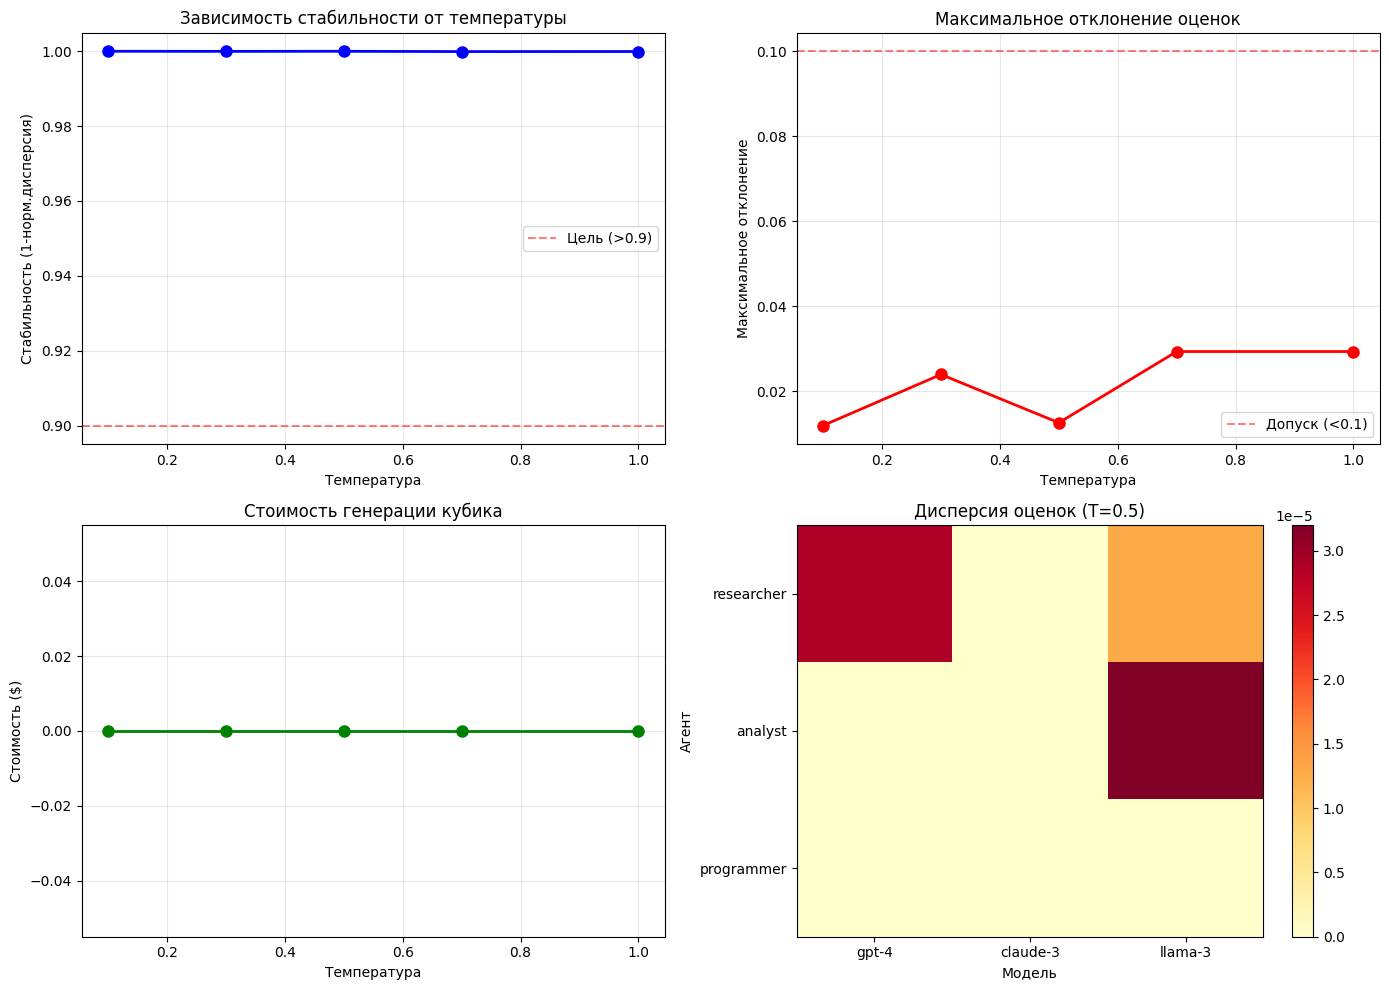


🚀 ЭКСПЕРИМЕНТ 2: Сравнение разных моделей для оракула

🤖 СРАВНЕНИЕ СТАБИЛЬНОСТИ МОДЕЛЕЙ ОРАКУЛА
   Модели: gpt4, claude3, llama3
   Прогонов на модель: 3

🔧 Модель оракула: gpt4
   Прогон 1/3... Генерация кубика (5×3×3)
Уточнили 13 из 45 комбинаций через LLM
Стоимость: $0.0000
Оценок через LLM: 13
Размер кеша: 13
✅ $0.0000
   Прогон 2/3... Генерация кубика (5×3×3)
Уточнили 13 из 45 комбинаций через LLM
Стоимость: $0.0000
Оценок через LLM: 13
Размер кеша: 13
✅ $0.0000
   Прогон 3/3... Генерация кубика (5×3×3)
Уточнили 13 из 45 комбинаций через LLM
Стоимость: $0.0000
Оценок через LLM: 13
Размер кеша: 13
✅ $0.0000
   Стабильность: 1.000
   Средняя стоимость: $0.0000

🔧 Модель оракула: claude3
   Прогон 1/3... Генерация кубика (5×3×3)
Уточнили 13 из 45 комбинаций через LLM
Стоимость: $0.0013
Оценок через LLM: 13
Размер кеша: 13
✅ $0.0013
   Прогон 2/3... Генерация кубика (5×3×3)
Уточнили 13 из 45 комбинаций через LLM
Стоимость: $0.0013
Оценок через LLM: 13
Размер кеша: 13
✅ $0.0013
   Про

In [97]:
# 1. Создаем анализатор
analyzer = OracleStabilityAnalyzer(
    oracle_class=OptimizedOracleFixed,
    subtasks=subtasks,
    agents=agents,
    model_packages=model_packages
)

# 2. Запускаем эксперимент по стабильности (разные температуры)
print("🚀 ЭКСПЕРИМЕНТ 1: Анализ влияния температуры на стабильность")
results = analyzer.run_stability_experiment(
    n_runs=5,  # 5 прогонов на каждую температуру
    use_llm_for=0.3,
    temperatures=[0.1, 0.3, 0.5, 0.7, 1.0]
)

# 3. Анализируем результаты
stability_analysis = analyzer.analyze_stability()

# 4. Визуализируем
analyzer.visualize_stability_results("stability_analysis.png")

# 5. Сравниваем разные модели оракула
print("\n" + "="*60)
print("🚀 ЭКСПЕРИМЕНТ 2: Сравнение разных моделей для оракула")
model_comparison = analyzer.compare_oracle_models(
    oracle_models=["gpt4", "claude3", "llama3"],
    n_runs_per_model=3
)

In [103]:
import pandas as pd

data = {
    'Модель': ['gpt4', 'claude3', 'llama3'],
    'Стабильность': [1.000, 1.000, 0.998],
    'Стоимость': [0.0000, 0.0013, 0.0000],
    'Отклонение': [0.014, 0.000, 0.116]
}
df = pd.DataFrame(data)
df.set_index('Модель', inplace=True)
df

,Стабильность,Стоимость,Отклонение
Модель,,,
gpt4,1.000,0.0000,0.014
claude3,1.000,0.0013,0.000
llama3,0.998,0.0000,0.116


In [99]:
def quick_stability_test(oracle_class, subtasks, agents, model_packages, n_runs=5):
    """
    Быстрый тест стабильности
    """
    print(f"БЫСТРЫЙ ТЕСТ СТАБИЛЬНОСТИ ({n_runs} прогонов)")
    print("="*60)

    all_cubes = []
    costs = []

    for i in range(n_runs):
        print(f"Прогон {i+1}/{n_runs}...", end=" ")

        oracle = oracle_class(
            temperature=0.1,
            model_for_evaluation="gpt4",
            max_tokens_per_eval=15,
            skip_low_compatibility=True
        )

        cube = oracle.generate_utility_cube_fast(
            subtasks=subtasks,
            agents=agents,
            model_packages=model_packages,
            use_llm_for=0.3
        )

        all_cubes.append(cube)
        costs.append(oracle.total_cost)
        print(f" ${oracle.total_cost:.4f}")

    # Анализ
    mean_cube = np.mean(all_cubes, axis=0)
    std_cube = np.std(all_cubes, axis=0)

    print(f"\nРЕЗУЛЬТАТЫ:")
    print(f"  Средняя стоимость: ${np.mean(costs):.4f} ± ${np.std(costs):.4f}")
    print(f"  Средняя оценка: {np.mean(mean_cube):.3f}")
    print(f"  Среднее отклонение: {np.mean(std_cube):.3f}")
    print(f"  Максимальное отклонение: {np.max(std_cube):.3f}")

    # Проверяем критические отклонения
    critical_threshold = 0.2  # 20% изменение
    critical_points = np.sum(std_cube > critical_threshold)
    total_points = std_cube.size

    print(f"  Критических отклонений (>0.2): {critical_points}/{total_points} "
          f"({critical_points/total_points*100:.1f}%)")

    return all_cubes, mean_cube, std_cube

# Запуск быстрого теста
print("Быстрый тест стабильности...")
all_cubes, mean_cube, std_cube = quick_stability_test(
    OptimizedOracleFixed, subtasks, agents, model_packages, n_runs=3
)

Быстрый тест стабильности...
БЫСТРЫЙ ТЕСТ СТАБИЛЬНОСТИ (3 прогонов)
Прогон 1/3... Генерация кубика (5×3×3)
Уточнили 13 из 45 комбинаций через LLM
Стоимость: $0.0000
Оценок через LLM: 13
Размер кеша: 13
 $0.0000
Прогон 2/3... Генерация кубика (5×3×3)
Уточнили 13 из 45 комбинаций через LLM
Стоимость: $0.0000
Оценок через LLM: 13
Размер кеша: 13
 $0.0000
Прогон 3/3... Генерация кубика (5×3×3)
Уточнили 13 из 45 комбинаций через LLM
Стоимость: $0.0000
Оценок через LLM: 13
Размер кеша: 13
 $0.0000

РЕЗУЛЬТАТЫ:
  Средняя стоимость: $0.0000 ± $0.0000
  Средняя оценка: 0.338
  Среднее отклонение: 0.000
  Максимальное отклонение: 0.000
  Критических отклонений (>0.2): 0/45 (0.0%)


### **Анализ согласованности решений**

In [100]:
def analyze_decision_consistency(cubes, subtasks, agents, model_packages):
    """
    Анализ согласованности решений между прогонами
    """
    print("\n🤝 АНАЛИЗ СОГЛАСОВАННОСТИ РЕШЕНИЙ")
    print("="*60)

    n_runs = len(cubes)
    n_tasks = cubes[0].shape[0]

    # Для каждой задачи находим лучшую комбинацию в каждом прогоне
    best_decisions = []

    for run_idx, cube in enumerate(cubes):
        run_decisions = []
        for task_idx in range(n_tasks):
            best_idx = np.unravel_index(
                np.argmax(cube[task_idx]),
                (len(agents), len(model_packages))
            )
            run_decisions.append({
                'task_idx': task_idx,
                'agent_idx': best_idx[0],
                'model_idx': best_idx[1],
                'score': cube[task_idx][best_idx]
            })
        best_decisions.append(run_decisions)

    # Анализируем согласованность
    print(f"Задач: {n_tasks}, Прогонов: {n_runs}")
    print("\n📋 СОГЛАСОВАННОСТЬ ПО ЗАДАЧАМ:")

    for task_idx in range(n_tasks):
        print(f"\nЗадача {task_idx+1}: {subtasks[task_idx].description[:50]}...")

        # Собираем решения для этой задачи
        task_decisions = []
        for run_idx in range(n_runs):
            decision = best_decisions[run_idx][task_idx]
            task_decisions.append(decision)

        # Проверяем одинаковость решений
        unique_decisions = set()
        for d in task_decisions:
            key = (d['agent_idx'], d['model_idx'])
            unique_decisions.add(key)

        consistency = 1 - (len(unique_decisions) - 1) / (n_runs - 1) if n_runs > 1 else 1

        print(f"  Уникальных решений: {len(unique_decisions)} из {n_runs}")
        print(f"  Согласованность: {consistency:.1%}")

        # Показываем распределение решений
        if len(unique_decisions) > 1:
            print(f"  Распределение решений:")
            decision_counts = {}
            for d in task_decisions:
                key = (d['agent_idx'], d['model_idx'])
                decision_counts[key] = decision_counts.get(key, 0) + 1

            for (agent_idx, model_idx), count in decision_counts.items():
                agent_name = agents[agent_idx].role.value
                model_name = model_packages[model_idx].model.value
                percentage = count / n_runs * 100
                print(f"    • {agent_name} + {model_name}: {count} раз ({percentage:.0f}%)")

# Запуск анализа
analyze_decision_consistency(all_cubes, subtasks, agents, model_packages)


🤝 АНАЛИЗ СОГЛАСОВАННОСТИ РЕШЕНИЙ
Задач: 5, Прогонов: 3

📋 СОГЛАСОВАННОСТЬ ПО ЗАДАЧАМ:

Задача 1: Identify the region where the pharmacy is located...
  Уникальных решений: 1 из 3
  Согласованность: 100.0%

Задача 2: Determine the specific disease outbreaks in that r...
  Уникальных решений: 1 из 3
  Согласованность: 100.0%

Задача 3: Research available vaccines for those diseases...
  Уникальных решений: 1 из 3
  Согласованность: 100.0%

Задача 4: Calculate the costs of vaccines and transportation...
  Уникальных решений: 1 из 3
  Согласованность: 100.0%

Задача 5: Provide a summary report with recommendations...
  Уникальных решений: 1 из 3
  Согласованность: 100.0%


# **Роутер**

### **Классические методы распределения**

**1. Utilitarian Social Welfare (USW)**

In [105]:
def utilitarian_allocation(utility_cube):
    """
    Максимизация суммы полезностей
    Каждой задаче назначаем лучшую комбинацию
    """
    allocations = []
    for task_idx in range(len(utility_cube)):
        best_agent, best_model = np.unravel_index(
            np.argmax(utility_cube[task_idx]),
            utility_cube[task_idx].shape
        )
        allocations.append((best_agent, best_model))
    return allocations

**2. Nash Social Welfare (NSW)**

In [106]:
def nash_allocation(utility_cube, task_priorities=None):
    """
    Максимизация произведения полезностей
    Баланс между эффективностью и справедливостью
    """
    n_tasks, n_agents, n_models = utility_cube.shape

    # Задача оптимизации: max ∏(u_i)^w_i
    # Где w_i = приоритет задачи (по умолчанию 1/n)
    if task_priorities is None:
        task_priorities = np.ones(n_tasks) / n_tasks

    # Решаем как задачу линейного программирования
    # или используем жадный алгоритм с логарифмической полезностью
    allocations = []

    # Жадный NSW: максимизируем сумму логарифмов
    for task_idx in range(n_tasks):
        # Взвешенная логарифмическая полезность
        weighted_log_utility = task_priorities[task_idx] * np.log(
            utility_cube[task_idx] + 1e-10
        )
        best_agent, best_model = np.unravel_index(
            np.argmax(weighted_log_utility),
            weighted_log_utility.shape
        )
        allocations.append((best_agent, best_model))

    return allocations

**3. Envy-Free (EF) Распределение**

Ни один агент не завидует другому
    Агенты не хотят обменяться назначенными задачами

In [107]:
def envy_free_allocation(utility_cube, agents_capacities=None):
    """
    Ни один агент не завидует другому
    Агенты не хотят обменяться назначенными задачами
    """
    from scipy.optimize import linear_sum_assignment

    n_tasks, n_agents, n_models = utility_cube.shape

    if agents_capacities is None:
        agents_capacities = [n_tasks // n_agents] * n_agents

    # Создаем расширенную матрицу для Венгерского алгоритма
    # Каждый агент может взять несколько задач
    expanded_matrix = []
    agent_indices = []

    for agent_idx in range(n_agents):
        for _ in range(agents_capacities[agent_idx]):
            # Для каждой "копии" агента берем лучшую модель для каждой задачи
            best_utilities = np.max(utility_cube[:, agent_idx, :], axis=1)
            expanded_matrix.append(best_utilities)
            agent_indices.append(agent_idx)

    # Решаем задачу назначения
    expanded_matrix = np.array(expanded_matrix)
    row_ind, col_ind = linear_sum_assignment(-expanded_matrix)

    # Восстанавливаем распределение
    allocations = []
    task_assignments = [-1] * n_tasks

    for task_idx in col_ind:
        assigned_agent_copy = row_ind[np.where(col_ind == task_idx)[0][0]]
        assigned_agent = agent_indices[assigned_agent_copy]

        # Находим лучшую модель для этого агента и задачи
        best_model = np.argmax(utility_cube[task_idx, assigned_agent, :])
        allocations.append((assigned_agent, best_model))

    return allocations

### **Теоретико-игровые методы**

**4. Shapley Value Распределение**

In [108]:
def shapley_allocation(utility_cube):
    """
    Распределение по вкладу Шепли
    Справедливое распределение "прибыли" от кооперации
    """
    n_tasks, n_agents, n_models = utility_cube.shape

    # Для каждой задачи вычисляем вклад каждого агента
    shapley_values = np.zeros((n_tasks, n_agents))

    for task_idx in range(n_tasks):
        task_utilities = utility_cube[task_idx]

        # Простая аппроксимация: вклад = разница между лучшей
        # комбинацией с агентом и без него
        best_overall = np.max(task_utilities)

        for agent_idx in range(n_agents):
            # Утилита без этого агента
            mask = np.ones(n_agents, dtype=bool)
            mask[agent_idx] = False

            if np.any(mask):
                utilities_without_agent = task_utilities[mask, :]
                best_without = np.max(utilities_without_agent)
            else:
                best_without = 0

            # Вклад агента = насколько он улучшает результат
            best_with_agent = np.max(task_utilities[agent_idx, :])
            shapley_values[task_idx, agent_idx] = max(0, best_with_agent - best_without)

    # Распределяем задачи агентам с наибольшим вкладом
    allocations = []
    for task_idx in range(n_tasks):
        best_agent = np.argmax(shapley_values[task_idx])
        best_model = np.argmax(utility_cube[task_idx, best_agent, :])
        allocations.append((best_agent, best_model))

    return allocations

**5. Proportional Fairness (PF)**

In [109]:
def proportional_fair_allocation(utility_cube, alpha=2):
    """
    Пропорционально справедливое распределение
    max ∑ (u_i)^(1-alpha) / (1-alpha) при alpha≠1
    При alpha→1 переходит в NSW
    """
    n_tasks, n_agents, n_models = utility_cube.shape

    allocations = []
    agent_loads = np.zeros(n_agents)  # Сколько задач уже у агента

    for task_idx in range(n_tasks):
        # Взвешиваем полезность обратно пропорционально загрузке агента
        fairness_weights = 1 / (agent_loads + 1)**(1/alpha)
        weighted_utilities = utility_cube[task_idx] * fairness_weights[:, np.newaxis]

        best_agent, best_model = np.unravel_index(
            np.argmax(weighted_utilities),
            weighted_utilities.shape
        )

        allocations.append((best_agent, best_model))
        agent_loads[best_agent] += 1

    return allocations

### Роутер с теоретико-игровыми критериями

In [104]:
class GameTheoreticRouter:
    """Роутер с теоретико-игровыми критериями"""

    def __init__(self,
                 fairness_criterion: str = "NSW",  # "NSW", "EF", "USW", "PF"
                 optimization_method: str = "greedy",  # "greedy", "mip", "rl"
                 budget: float = 1.0,
                 cost_weight: float = 0.3):

        self.fairness_criterion = fairness_criterion
        self.optimization_method = optimization_method
        self.budget = budget
        self.cost_weight = cost_weight  # Вес стоимости в целевой функции

    def allocate(self,
                 utility_cube: np.ndarray,
                 model_costs: List[float],
                 task_priorities: Optional[List[float]] = None) -> List[Tuple[int, int]]:
        """
        Основной метод распределения

        Returns:
            Список пар (agent_idx, model_idx) для каждой задачи
        """

        if self.fairness_criterion == "NSW":
            return self._nash_allocation(utility_cube, model_costs)
        elif self.fairness_criterion == "EF":
            return self._envy_free_allocation(utility_cube, model_costs)
        elif self.fairness_criterion == "USW":
            return self._utilitarian_allocation(utility_cube, model_costs)
        elif self.fairness_criterion == "PF":
            return self._proportional_allocation(utility_cube, model_costs)

## **NashSocialWelfareRouter**

In [114]:
subtasks = [
    Subtask(
        id="task1_step_1",
        description="Identify the region where the pharmacy is located",
        task_type=TaskType.RESEARCH,  # поиск информации
        parent_task_id="GAIA_001",
        step_number=1
    ),
    Subtask(
        id="task1_step_2",
        description="Determine the specific disease outbreaks in that region",
        task_type=TaskType.ANALYSIS,  # анализ
        parent_task_id="GAIA_001",
        step_number=2
    ),
    Subtask(
        id="task1_step_3",
        description="Research available vaccines for those diseases",
        task_type=TaskType.RESEARCH,  # поиск
        parent_task_id="GAIA_001",
        step_number=3
    ),
    Subtask(
        id="task1_step_4",
        description="Calculate the costs of vaccines and transportation",
        task_type=TaskType.ANALYSIS,  # анализ + вычисления
        parent_task_id="GAIA_001",
        step_number=4
    ),
    Subtask(
        id="task1_step_5",
        description="Provide a summary report with recommendations",
        task_type=TaskType.SUMMARIZATION,  # суммаризация
        parent_task_id="GAIA_001",
        step_number=5
    )
]
agents = [
    Agent(
        id="agent_researcher",
        role=AgentRole.RESEARCHER,
        tools=["web_search", "data_collection"]
    ),
    Agent(
        id="agent_analyst",
        role=AgentRole.ANALYST,
        tools=["statistical_analysis", "data_interpretation"]
    ),
    Agent(
        id="agent_programmer",
        role=AgentRole.PROGRAMMER,
        tools=["python", "data_visualization"]
    )
]

model_packages = [
    ModelPackage(
        model=LLMModel.GPT4,  # GPT-4o-mini
        token_budget=2000,
        cost=0.001
    ),
    ModelPackage(
        model=LLMModel.CLAUDE3,  # Claude-3 Haiku
        token_budget=3000,
        cost=0.001
    ),
    ModelPackage(
        model=LLMModel.LLAMA3,  # Llama-3 8B
        token_budget=4000,
        cost=0.001
    )
]

# Создаем оракул
oracle = OptimizedOracleFixed(
    temperature=0.1,
    model_for_evaluation="gpt4",  # "gpt4", "claude3" или "llama3"
    max_tokens_per_eval=15,
    skip_low_compatibility=True
)

# Генерируем кубик
utility_cube = oracle.generate_utility_cube_fast(
    subtasks=subtasks,
    agents=agents,
    model_packages=model_packages,
    use_llm_for=0.3
)

Генерация кубика (5×3×3)
Уточнили 13 из 45 комбинаций через LLM
Стоимость: $0.0000
Оценок через LLM: 13
Размер кеша: 13


In [115]:
utility_cube

array([[[0.66    , 0.65    , 0.6     ],
        [0.255   , 0.24108 , 0.2205  ],
        [0.1275  , 0.12054 , 0.11025 ]],

       [[0.64    , 0.29841 , 0.275625],
        [0.67    , 0.66    , 0.61    ],
        [0.225   , 0.21315 , 0.196875]],

       [[0.69    , 0.68    , 0.62    ],
        [0.255   , 0.24108 , 0.2205  ],
        [0.1275  , 0.12054 , 0.11025 ]],

       [[0.315   , 0.29841 , 0.275625],
        [0.67    , 0.66    , 0.58    ],
        [0.225   , 0.21315 , 0.196875]],

       [[0.205   , 0.2156  , 0.189   ],
        [0.287   , 0.30184 , 0.2646  ],
        [0.164   , 0.17248 , 0.1512  ]]])

In [118]:
# !pip install ortools

In [121]:
import numpy as np
from typing import List, Tuple, Dict, Optional

class SimpleRouter:
    """Минимальный роутер без внешних зависимостей"""

    @staticmethod
    def utilitarian_allocation(utility_cube: np.ndarray) -> List[Tuple[int, int]]:
        """USW: максимизация общей полезности"""
        n_tasks = utility_cube.shape[0]
        allocations = []

        for task_idx in range(n_tasks):
            # Находим лучшую комбинацию для каждой задачи
            best_agent, best_model = np.unravel_index(
                np.argmax(utility_cube[task_idx]),
                utility_cube[task_idx].shape
            )
            allocations.append((best_agent, best_model))

        return allocations

    @staticmethod
    def nash_allocation(utility_cube: np.ndarray, fairness_weight: float = 0.7) -> List[Tuple[int, int]]:
        """NSW: баланс эффективности и справедливости"""
        n_tasks, n_agents, n_models = utility_cube.shape

        allocations = []
        agent_utilities = np.zeros(n_agents)

        for _ in range(n_tasks):
            best_score = -np.inf
            best_task = -1
            best_agent = -1
            best_model = -1

            # Перебираем все оставшиеся задачи
            remaining_tasks = [i for i in range(n_tasks) if i not in [a[0] for a in allocations]]

            for task_idx in remaining_tasks:
                for agent_idx in range(n_agents):
                    for model_idx in range(n_models):
                        current_utility = utility_cube[task_idx, agent_idx, model_idx]

                        # NSW через логарифмическую полезность
                        if agent_utilities[agent_idx] > 0:
                            marginal_gain = np.log(agent_utilities[agent_idx] + current_utility + 1e-10) - \
                                         np.log(agent_utilities[agent_idx] + 1e-10)
                        else:
                            marginal_gain = np.log(current_utility + 1e-10)

                        # Учет fairness веса
                        score = marginal_gain * (1 - fairness_weight) + \
                               current_utility * fairness_weight

                        if score > best_score:
                            best_score = score
                            best_task = task_idx
                            best_agent = agent_idx
                            best_model = model_idx

            if best_task != -1:
                allocations.append((best_agent, best_model))
                agent_utilities[best_agent] += utility_cube[best_task, best_agent, best_model]

        return allocations

    @staticmethod
    def round_robin_allocation(utility_cube: np.ndarray) -> List[Tuple[int, int]]:
        """Простое циклическое распределение"""
        n_tasks, n_agents, n_models = utility_cube.shape
        allocations = []

        for task_idx in range(n_tasks):
            agent_idx = task_idx % n_agents
            model_idx = task_idx % n_models
            allocations.append((agent_idx, model_idx))

        return allocations

    @staticmethod
    def evaluate_allocation(allocations: List[Tuple[int, int]],
                          utility_cube: np.ndarray) -> Dict:
        """Оценка качества распределения"""
        total_utility = 0
        agent_utilities = {}

        for task_idx, (agent_idx, model_idx) in enumerate(allocations):
            utility = utility_cube[task_idx, agent_idx, model_idx]
            total_utility += utility

            if agent_idx not in agent_utilities:
                agent_utilities[agent_idx] = 0
            agent_utilities[agent_idx] += utility

        # Fairness метрика (простая)
        if agent_utilities:
            fairness_score = 1 - (max(agent_utilities.values()) - min(agent_utilities.values())) / (total_utility + 1e-10)
        else:
            fairness_score = 0

        return {
            'total_utility': total_utility,
            'fairness_score': fairness_score,
            'agent_utilities': agent_utilities
        }

# БЫСТРЫЙ ТЕСТ
print("Минимальный тест роутера")
print("="*60)

# Создаем тестовые данные на основе вашего utility_cube
print(f"Utility cube shape: {utility_cube.shape}")
print(f"Utility cube values (округленные):")
print(np.round(utility_cube, 3))

# Тестируем методы
print("\n1. Утилитарное распределение (USW):")
usw_alloc = SimpleRouter.utilitarian_allocation(utility_cube)
usw_eval = SimpleRouter.evaluate_allocation(usw_alloc, utility_cube)
print(f"   Всего задач: {len(usw_alloc)}")
print(f"   Общая полезность: {usw_eval['total_utility']:.3f}")
print(f"   Fairness score: {usw_eval['fairness_score']:.3f}")
print(f"   Распределение: {usw_alloc}")

print("\n2. Распределение Нэша (NSW):")
nash_alloc = SimpleRouter.nash_allocation(utility_cube, fairness_weight=0.7)
nash_eval = SimpleRouter.evaluate_allocation(nash_alloc, utility_cube)
print(f"   Общая полезность: {nash_eval['total_utility']:.3f}")
print(f"   Fairness score: {nash_eval['fairness_score']:.3f}")
print(f"   Распределение: {nash_alloc}")

print("\n3. Циклическое распределение (Round Robin):")
rr_alloc = SimpleRouter.round_robin_allocation(utility_cube)
rr_eval = SimpleRouter.evaluate_allocation(rr_alloc, utility_cube)
print(f"   Общая полезность: {rr_eval['total_utility']:.3f}")
print(f"   Fairness score: {rr_eval['fairness_score']:.3f}")
print(f"   Распределение: {rr_alloc}")

# Сравнение
print("\n" + "="*60)
print("СРАВНЕНИЕ МЕТОДОВ:")
print("-"*60)

methods = [
    ("USW", usw_alloc, usw_eval),
    ("NSW", nash_alloc, nash_eval),
    ("Round Robin", rr_alloc, rr_eval)
]

best_method = None
best_utility = -1

for name, alloc, eval_result in methods:
    print(f"\n{name}:")
    print(f"  Общая полезность: {eval_result['total_utility']:.3f}")
    print(f"  Fairness score: {eval_result['fairness_score']:.3f}")

    # Детальное распределение
    print(f"  Распределение по агентам:")
    for agent_idx, utility in eval_result['agent_utilities'].items():
        agent_name = f"Agent {agent_idx}"
        if agent_idx < len(agents):
            agent_name = agents[agent_idx].role.value
        print(f"    {agent_name}: {utility:.3f}")

    if eval_result['total_utility'] > best_utility:
        best_utility = eval_result['total_utility']
        best_method = name

print(f"\nЛучший метод по полезности: {best_method} ({best_utility:.3f})")

# Визуализация распределения
print("\n" + "="*60)
print("ДЕТАЛЬНОЕ РАСПРЕДЕЛЕНИЕ NSW:")
print("-"*60)

for task_idx, (agent_idx, model_idx) in enumerate(nash_alloc):
    if task_idx < len(subtasks):
        subtask = subtasks[task_idx]
        agent = agents[agent_idx] if agent_idx < len(agents) else f"Agent {agent_idx}"
        model_pkg = model_packages[model_idx] if model_idx < len(model_packages) else f"Model {model_idx}"
        utility = utility_cube[task_idx, agent_idx, model_idx]

        task_desc = subtask.description[:40] + "..." if len(subtask.description) > 40 else subtask.description

        print(f"Задача {task_idx+1}: {task_desc}")

        if isinstance(agent, Agent):
            print(f"  → Агент: {agent.role.value}")
        else:
            print(f"  → Агент: {agent}")

        if isinstance(model_pkg, ModelPackage):
            print(f"  → Модель: {model_pkg.model.value}")
            print(f"  → Стоимость: ${model_pkg.cost:.4f}")
        else:
            print(f"  → Модель: {model_pkg}")

        print(f"  → Полезность: {utility:.3f}")
        print()

Минимальный тест роутера
Utility cube shape: (5, 3, 3)
Utility cube values (округленные):
[[[0.66  0.65  0.6  ]
  [0.255 0.241 0.22 ]
  [0.128 0.121 0.11 ]]

 [[0.64  0.298 0.276]
  [0.67  0.66  0.61 ]
  [0.225 0.213 0.197]]

 [[0.69  0.68  0.62 ]
  [0.255 0.241 0.22 ]
  [0.128 0.121 0.11 ]]

 [[0.315 0.298 0.276]
  [0.67  0.66  0.58 ]
  [0.225 0.213 0.197]]

 [[0.205 0.216 0.189]
  [0.287 0.302 0.265]
  [0.164 0.172 0.151]]]

1. Утилитарное распределение (USW):
   Всего задач: 5
   Общая полезность: 2.992
   Fairness score: 0.902
   Распределение: [(np.int64(0), np.int64(0)), (np.int64(1), np.int64(0)), (np.int64(0), np.int64(0)), (np.int64(1), np.int64(0)), (np.int64(1), np.int64(1))]

2. Распределение Нэша (NSW):
   Общая полезность: 2.510
   Fairness score: 1.000
   Распределение: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]

3. Циклическое распределение (Round Robin):
   Общая полезность: 2.047
   Fairness score: 0.578
   Распределение: [(0, 0), (1, 1), (2, 2), (0, 0), (1, 1)]

СРАВНЕ

      Utility Cube: [5 задач × 3 агента × 3 модели]

      USW:   [(0,0), (1,0), (0,0), (1,0), (1,1)]   2.992
      NSW:   [(0,0), (0,0), (0,0), (0,0), (0,0)]   2.510
      Round: [(0,0), (1,1), (2,2), (0,0), (1,1)]   2.047

# **Загрузка GAIA**

In [122]:
!pip install datasets -q

In [126]:
!pip install huggingface-hub
!huggingface-cli login

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
The token `gaia` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggi

In [128]:
from datasets import load_dataset
import pandas as pd

# Теперь, после авторизации, попробуем загрузить GAIA
try:
    # Попробуем разные конфигурации GAIA
    print("Пытаемся загрузить датасет GAIA...")

    # Вариант 1: Без указания конфигурации
    dataset = load_dataset("gaia-benchmark/GAIA", split="validation")

except Exception as e:
    print(f"Ошибка при загрузке без конфигурации: {e}")
    print("\nПробуем с конкретной конфигурацией...")

    try:
        # Вариант 2: С конкретной конфигурацией
        dataset = load_dataset("gaia-benchmark/GAIA", "2023_all", split="validation")

    except Exception as e2:
        print(f"Ошибка с конфигурацией '2023_all': {e2}")
        print("\nПробуем другие конфигурации...")

        # Список возможных конфигураций для тестирования
        configs = ["2023_level1", "2023_level2", "2023_level3", "main", "test"]

        for config in configs:
            try:
                dataset = load_dataset("gaia-benchmark/GAIA", config, split="validation")
                print(f"✓ Успешно загружено с конфигурацией: {config}")
                break
            except:
                print(f"✗ Конфигурация {config} не сработала")
                continue

# Проверяем, удалось ли загрузить датасет
if 'dataset' in locals():
    # Конвертируем в pandas DataFrame для удобного отображения
    df = dataset.to_pandas()

    print(f"\nДанасе успешно загружен!")
    print(f"Всего строк: {len(df)}")
    print(f"Колонки: {df.columns.tolist()}")

    print("\n" + "="*50)
    print("Первые 15 строк датасета:")
    print("="*50)

    # Отображаем первые 15 строк
    with pd.option_context('display.max_rows', 15,
                          'display.max_columns', None,
                          'display.width', None,
                          'display.max_colwidth', 100):
        print(df.head(15))

    # Показываем информацию о типах данных
    print("\n" + "="*50)
    print("Информация о датасете:")
    print("="*50)
    print(df.info())

else:
    print("\nНе удалось загрузить датасет GAIA")

Пытаемся загрузить датасет GAIA...
Ошибка при загрузке без конфигурации: Config name is missing.
Please pick one among the available configs: ['2023_all', '2023_level1', '2023_level2', '2023_level3']
Example of usage:
	`load_dataset('gaia-benchmark/GAIA', '2023_all')`

Пробуем с конкретной конфигурацией...


2023/test/metadata.parquet:   0%|          | 0.00/75.3k [00:00<?, ?B/s]

2023/validation/metadata.parquet:   0%|          | 0.00/117k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/301 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/165 [00:00<?, ? examples/s]


✅ Данасе успешно загружен!
📊 Всего строк: 165
📋 Колонки: ['task_id', 'Question', 'Level', 'Final answer', 'file_name', 'file_path', 'Annotator Metadata']

Первые 15 строк датасета:
                                 task_id  \
0   c61d22de-5f6c-4958-a7f6-5e9707bd3466   
1   17b5a6a3-bc87-42e8-b0fb-6ab0781ef2cc   
2   04a04a9b-226c-43fd-b319-d5e89743676f   
3   14569e28-c88c-43e4-8c32-097d35b9a67d   
4   e1fc63a2-da7a-432f-be78-7c4a95598703   
5   32102e3e-d12a-4209-9163-7b3a104efe5d   
6   8e867cd7-cff9-4e6c-867a-ff5ddc2550be   
7   3627a8be-a77f-41bb-b807-7e1bd4c0ebdf   
8   7619a514-5fa8-43ef-9143-83b66a43d7a4   
9   ec09fa32-d03f-4bf8-84b0-1f16922c3ae4   
10  676e5e31-a554-4acc-9286-b60d90a92d26   
11  7dd30055-0198-452e-8c25-f73dbe27dcb8   
12  2a649bb1-795f-4a01-b3be-9a01868dae73   
13  87c610df-bef7-4932-b950-1d83ef4e282b   
14  624cbf11-6a41-4692-af9c-36b3e5ca3130   

                                                                                               Question  \
0   A 

**Берем первые 10 значений из Annotator Metadata и тестируем роутер на этих подзадачах.**

In [129]:
import json
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt

# Используем уже написанные классы (предполагаем, что они уже определены)
# Если они в другом файле, импортируем их здесь

# Функция для извлечения подзадач из Annotator Metadata
def extract_subtasks_from_metadata(metadata_str, task_id, task_index):
    """Извлекает подзадачи из поля Annotator Metadata"""
    try:
        # Парсим JSON строку
        if isinstance(metadata_str, str):
            metadata = json.loads(metadata_str)
        else:
            metadata = metadata_str

        # Ищем поле Steps
        steps = metadata.get('Steps', [])

        # Если steps строка, пробуем разбить по номерам
        if isinstance(steps, str):
            # Пробуем разные форматы
            # Формат 1: "1. Step one\n2. Step two"
            if '\n' in steps:
                step_lines = [line.strip() for line in steps.split('\n') if line.strip()]
                steps_list = []
                for line in step_lines:
                    # Удаляем номер шага (1., 2., и т.д.)
                    for i in range(1, 20):
                        if line.startswith(f'{i}. '):
                            steps_list.append(line[len(f'{i}. '):])
                            break
                    else:
                        steps_list.append(line)
                steps = steps_list
            else:
                # Если нет переносов, используем всю строку как один шаг
                steps = [steps]

        subtasks = []
        for i, step in enumerate(steps, 1):
            # Определяем тип задачи
            step_lower = str(step).lower()

            if any(word in step_lower for word in ["find", "search", "look up", "gather", "identify", "go to", "navigate"]):
                task_type = TaskType.RESEARCH
            elif any(word in step_lower for word in ["analyze", "compare", "calculate", "evaluate", "assess", "parse", "count"]):
                task_type = TaskType.ANALYSIS
            elif any(word in step_lower for word in ["code", "program", "implement", "function", "write code", "python"]):
                task_type = TaskType.CODING
            elif any(word in step_lower for word in ["reason", "deduce", "infer", "if-then", "consider", "evaluate"]):
                task_type = TaskType.REASONING
            elif any(word in step_lower for word in ["summarize", "conclude", "write", "report", "format", "organize"]):
                task_type = TaskType.SUMMARIZATION
            else:
                task_type = TaskType.ANALYSIS

            subtask = Subtask(
                id=f"{task_id}_step_{i}",
                description=str(step),
                task_type=task_type,
                parent_task_id=task_id,
                step_number=i
            )
            subtasks.append(subtask)

        return subtasks

    except Exception as e:
        print(f"⚠️ Ошибка при парсинге метаданных для задачи {task_index}: {e}")
        # Создаем дефолтную подзадачу
        return [Subtask(
            id=f"{task_id}_default",
            description=f"Task {task_index}: Error parsing metadata",
            task_type=TaskType.ANALYSIS,
            parent_task_id=task_id,
            step_number=1
        )]

# Функция для тестирования роутера на GAIA задачах
def test_router_on_gaia(df, router_class, router_name, n_tasks=10):
    """Тестирует роутер на GAIA задачах"""
    print(f"\n🧪 ТЕСТИРОВАНИЕ РОУТЕРА: {router_name}")
    print("="*60)

    # Инициализация агентов и моделей (те же что и раньше)
    agents = [
        Agent(id="agent_researcher", role=AgentRole.RESEARCHER, tools=["web_search", "data_collection"]),
        Agent(id="agent_analyst", role=AgentRole.ANALYST, tools=["statistical_analysis", "data_interpretation"]),
        Agent(id="agent_programmer", role=AgentRole.PROGRAMMER, tools=["python", "data_visualization"])
    ]

    model_packages = [
        ModelPackage(model=LLMModel.GPT4, token_budget=2000, cost=0.001),
        ModelPackage(model=LLMModel.CLAUDE3, token_budget=3000, cost=0.001),
        ModelPackage(model=LLMModel.LLAMA3, token_budget=4000, cost=0.001)
    ]

    # Инициализация оракула (используем ранее написанный)
    oracle = OptimizedOracleFixed(
        temperature=0.1,
        model_for_evaluation="gpt4",
        max_tokens_per_eval=15,
        skip_low_compatibility=True
    )

    # Инициализация роутера
    if router_name == "USW":
        router = SimpleRouter()  # Предполагаем, что у SimpleRouter есть утилитарный метод
    elif router_name == "NSW":
        router = SimpleRouter()  # Или другой класс для NSW
    else:
        router = SimpleRouter()  # Round Robin

    results = []

    # Берем первые n_tasks задач
    for i in range(min(n_tasks, len(df))):
        print(f"\n📋 Задача GAIA #{i+1}:")
        print(f"   ID: {df.iloc[i]['task_id']}")
        print(f"   Уровень: {df.iloc[i]['Level']}")

        # Извлекаем подзадачи
        metadata = df.iloc[i]['Annotator Metadata']
        subtasks = extract_subtasks_from_metadata(metadata, df.iloc[i]['task_id'], i+1)

        print(f"   Найдено подзадач: {len(subtasks)}")

        # Показываем первую подзадачу для примера
        if subtasks:
            print(f"   Пример подзадачи: {subtasks[0].description[:80]}...")

        # Генерируем utility_cube
        utility_cube = oracle.generate_utility_cube_fast(
            subtasks=subtasks,
            agents=agents,
            model_packages=model_packages,
            use_llm_for=0.3
        )

        # Применяем роутер
        if router_name == "USW":
            allocations = router.utilitarian_allocation(utility_cube)
        elif router_name == "NSW":
            allocations = router.nash_allocation(utility_cube, fairness_weight=0.7)
        else:  # Round Robin
            allocations = router.round_robin_allocation(utility_cube)

        # Оцениваем результат
        total_utility = 0
        agent_utilities = {agent.role.value: 0 for agent in agents}
        model_usage = {model_pkg.model.value: 0 for model_pkg in model_packages}

        for task_idx, (agent_idx, model_idx) in enumerate(allocations):
            if task_idx < len(subtasks):
                utility = utility_cube[task_idx, agent_idx, model_idx]
                total_utility += utility
                agent_utilities[agents[agent_idx].role.value] += utility
                model_usage[model_packages[model_idx].model.value] += 1

        # Сохраняем результаты
        task_result = {
            'task_id': df.iloc[i]['task_id'],
            'task_index': i+1,
            'level': df.iloc[i]['Level'],
            'num_subtasks': len(subtasks),
            'total_utility': total_utility,
            'avg_utility_per_task': total_utility / len(subtasks) if subtasks else 0,
            'agent_utilities': agent_utilities,
            'model_usage': model_usage,
            'allocations': allocations,
            'utility_cube_mean': np.mean(utility_cube) if len(subtasks) > 0 else 0
        }

        results.append(task_result)

        print(f"   📊 Результаты:")
        print(f"      Общая полезность: {total_utility:.3f}")
        print(f"      Средняя полезность: {task_result['avg_utility_per_task']:.3f}")
        print(f"      Использование моделей: {model_usage}")

    return results

# Функция для сравнения роутеров
def compare_routers_on_gaia(df, n_tasks=10):
    """Сравнивает разные роутеры на GAIA задачах"""

    # Инициализация SimpleRouter
    router = SimpleRouter()

    agents = [
        Agent(id="agent_researcher", role=AgentRole.RESEARCHER, tools=["web_search", "data_collection"]),
        Agent(id="agent_analyst", role=AgentRole.ANALYST, tools=["statistical_analysis", "data_interpretation"]),
        Agent(id="agent_programmer", role=AgentRole.PROGRAMMER, tools=["python", "data_visualization"])
    ]

    model_packages = [
        ModelPackage(model=LLMModel.GPT4, token_budget=2000, cost=0.001),
        ModelPackage(model=LLMModel.CLAUDE3, token_budget=3000, cost=0.001),
        ModelPackage(model=LLMModel.LLAMA3, token_budget=4000, cost=0.001)
    ]

    oracle = OptimizedOracleFixed(
        temperature=0.1,
        model_for_evaluation="gpt4",
        max_tokens_per_eval=15,
        skip_low_compatibility=True
    )

    results_by_router = {}

    # Тестируем каждый роутер
    for router_name, method in [("USW", "utilitarian"), ("NSW", "nash"), ("Round Robin", "round_robin")]:
        print(f"\n{'='*80}")
        print(f"🏃‍♂️ ТЕСТИРУЕМ РОУТЕР: {router_name}")
        print('='*80)

        router_results = []

        for i in range(min(n_tasks, len(df))):
            print(f"\n📋 Задача #{i+1}...", end=" ")

            # Извлекаем подзадачи
            metadata = df.iloc[i]['Annotator Metadata']
            subtasks = extract_subtasks_from_metadata(metadata, df.iloc[i]['task_id'], i+1)

            # Генерируем utility_cube
            utility_cube = oracle.generate_utility_cube_fast(
                subtasks=subtasks,
                agents=agents,
                model_packages=model_packages,
                use_llm_for=0.3
            )

            # Применяем роутер
            if method == "utilitarian":
                allocations = router.utilitarian_allocation(utility_cube)
            elif method == "nash":
                allocations = router.nash_allocation(utility_cube, fairness_weight=0.7)
            else:
                allocations = router.round_robin_allocation(utility_cube)

            # Оцениваем
            total_utility = 0
            agent_utilities = {agent.role.value: 0 for agent in agents}
            model_usage = {model_pkg.model.value: 0 for model_pkg in model_packages}

            for task_idx, (agent_idx, model_idx) in enumerate(allocations):
                if task_idx < len(subtasks):
                    utility = utility_cube[task_idx, agent_idx, model_idx]
                    total_utility += utility
                    agent_utilities[agents[agent_idx].role.value] += utility
                    model_usage[model_packages[model_idx].model.value] += 1

            router_results.append({
                'task_id': df.iloc[i]['task_id'],
                'total_utility': total_utility,
                'avg_utility': total_utility / len(subtasks) if subtasks else 0,
                'model_usage': model_usage,
                'agent_utilities': agent_utilities,
                'num_subtasks': len(subtasks)
            })

            print(f"✓ Полезность: {total_utility:.3f}")

        results_by_router[router_name] = router_results

    return results_by_router

# Визуализация результатов
def visualize_router_comparison(results_by_router):
    """Визуализирует сравнение роутеров"""

    router_names = list(results_by_router.keys())

    # Подготовка данных для графиков
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Средняя полезность по задачам
    avg_utilities = []
    for router_name in router_names:
        utilities = [r['avg_utility'] for r in results_by_router[router_name]]
        avg_utilities.append(np.mean(utilities) if utilities else 0)

    axes[0, 0].bar(router_names, avg_utilities, color=['blue', 'green', 'orange'])
    axes[0, 0].set_ylabel('Средняя полезность')
    axes[0, 0].set_title('Сравнение средней полезности')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # 2. Распределение полезности по задачам (боксплот)
    data_for_boxplot = []
    for router_name in router_names:
        utilities = [r['avg_utility'] for r in results_by_router[router_name]]
        data_for_boxplot.append(utilities)

    axes[0, 1].boxplot(data_for_boxplot, labels=router_names)
    axes[0, 1].set_ylabel('Полезность')
    axes[0, 1].set_title('Распределение полезности по задачам')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # 3. Использование моделей (суммарное)
    model_usage_total = {}
    colors = {'GPT-4': 'blue', 'Claude-3': 'green', 'Llama-3': 'orange'}

    for router_name in router_names:
        router_model_usage = {'GPT-4': 0, 'Claude-3': 0, 'Llama-3': 0}
        for result in results_by_router[router_name]:
            for model, count in result['model_usage'].items():
                # Приводим к стандартным именам
                if 'gpt' in model.lower():
                    router_model_usage['GPT-4'] += count
                elif 'claude' in model.lower():
                    router_model_usage['Claude-3'] += count
                elif 'llama' in model.lower():
                    router_model_usage['Llama-3'] += count

        model_usage_total[router_name] = router_model_usage

    # Строим stacked bar chart
    models = ['GPT-4', 'Claude-3', 'Llama-3']
    bottom = np.zeros(len(router_names))

    for i, model in enumerate(models):
        values = [model_usage_total[rn][model] for rn in router_names]
        axes[1, 0].bar(router_names, values, bottom=bottom, label=model, color=colors[model])
        bottom += values

    axes[1, 0].set_ylabel('Количество использований')
    axes[1, 0].set_title('Использование моделей по роутерам')
    axes[1, 0].legend()
    axes[1, 0].tick_params(axis='x', rotation=45)

    # 4. Нагрузка на агентов (для USW как пример)
    if 'USW' in results_by_router:
        agent_roles = ['researcher', 'analyst', 'programmer']
        agent_loads = {role: 0 for role in agent_roles}

        for result in results_by_router['USW']:
            for agent, utility in result['agent_utilities'].items():
                if agent in agent_loads:
                    agent_loads[agent] += utility

        axes[1, 1].bar(agent_roles, [agent_loads[r] for r in agent_roles],
                      color=['red', 'blue', 'green'])
        axes[1, 1].set_ylabel('Суммарная полезность')
        axes[1, 1].set_title('Нагрузка агентов (USW)')
        axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Выводим сводную статистику
    print("\n" + "="*80)
    print("📊 СВОДНАЯ СТАТИСТИКА ПО РОУТЕРАМ")
    print('='*80)

    for router_name in router_names:
        results = results_by_router[router_name]
        total_utilities = [r['total_utility'] for r in results]
        avg_utilities = [r['avg_utility'] for r in results]

        print(f"\n{router_name}:")
        print(f"  Средняя общая полезность: {np.mean(total_utilities):.3f} ± {np.std(total_utilities):.3f}")
        print(f"  Средняя полезность на подзадачу: {np.mean(avg_utilities):.3f} ± {np.std(avg_utilities):.3f}")

        # Статистика по моделям
        model_counts = {'GPT-4': 0, 'Claude-3': 0, 'Llama-3': 0}
        total_assignments = 0

        for result in results:
            for model, count in result['model_usage'].items():
                if 'gpt' in model.lower():
                    model_counts['GPT-4'] += count
                elif 'claude' in model.lower():
                    model_counts['Claude-3'] += count
                elif 'llama' in model.lower():
                    model_counts['Llama-3'] += count
                total_assignments += count

        if total_assignments > 0:
            print(f"  Распределение моделей:")
            for model, count in model_counts.items():
                percentage = count / total_assignments * 100
                print(f"    {model}: {count} ({percentage:.1f}%)")


🎯 ТЕСТИРОВАНИЕ РОУТЕРОВ НА GAIA DATASET
📋 Используем первые 10 задач GAIA
📊 Уровни сложности: {'2': 7, '1': 3}

🏃‍♂️ ТЕСТИРУЕМ РОУТЕР: USW

📋 Задача #1... Генерация кубика (12×3×3)
Уточнили 32 из 108 комбинаций через LLM
Стоимость: $0.0000
Оценок через LLM: 30
Размер кеша: 32
✓ Полезность: 8.630

📋 Задача #2... Генерация кубика (10×3×3)
Уточнили 27 из 90 комбинаций через LLM
Стоимость: $0.0000
Оценок через LLM: 57
Размер кеша: 59
✓ Полезность: 6.340

📋 Задача #3... Генерация кубика (3×3×3)
Уточнили 8 из 27 комбинаций через LLM
Стоимость: $0.0000
Оценок через LLM: 65
Размер кеша: 67
✓ Полезность: 1.840

📋 Задача #4... Генерация кубика (6×3×3)
Уточнили 16 из 54 комбинаций через LLM
Стоимость: $0.0000
Оценок через LLM: 81
Размер кеша: 83
✓ Полезность: 4.210

📋 Задача #5... Генерация кубика (4×3×3)
Уточнили 10 из 36 комбинаций через LLM
Стоимость: $0.0000
Оценок через LLM: 91
Размер кеша: 93
✓ Полезность: 2.720

📋 Задача #6... Генерация кубика (3×3×3)
Уточнили 8 из 27 комбинаций через LLM


/tmp/ipython-input-2963052593.py:299: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(data_for_boxplot, labels=router_names)


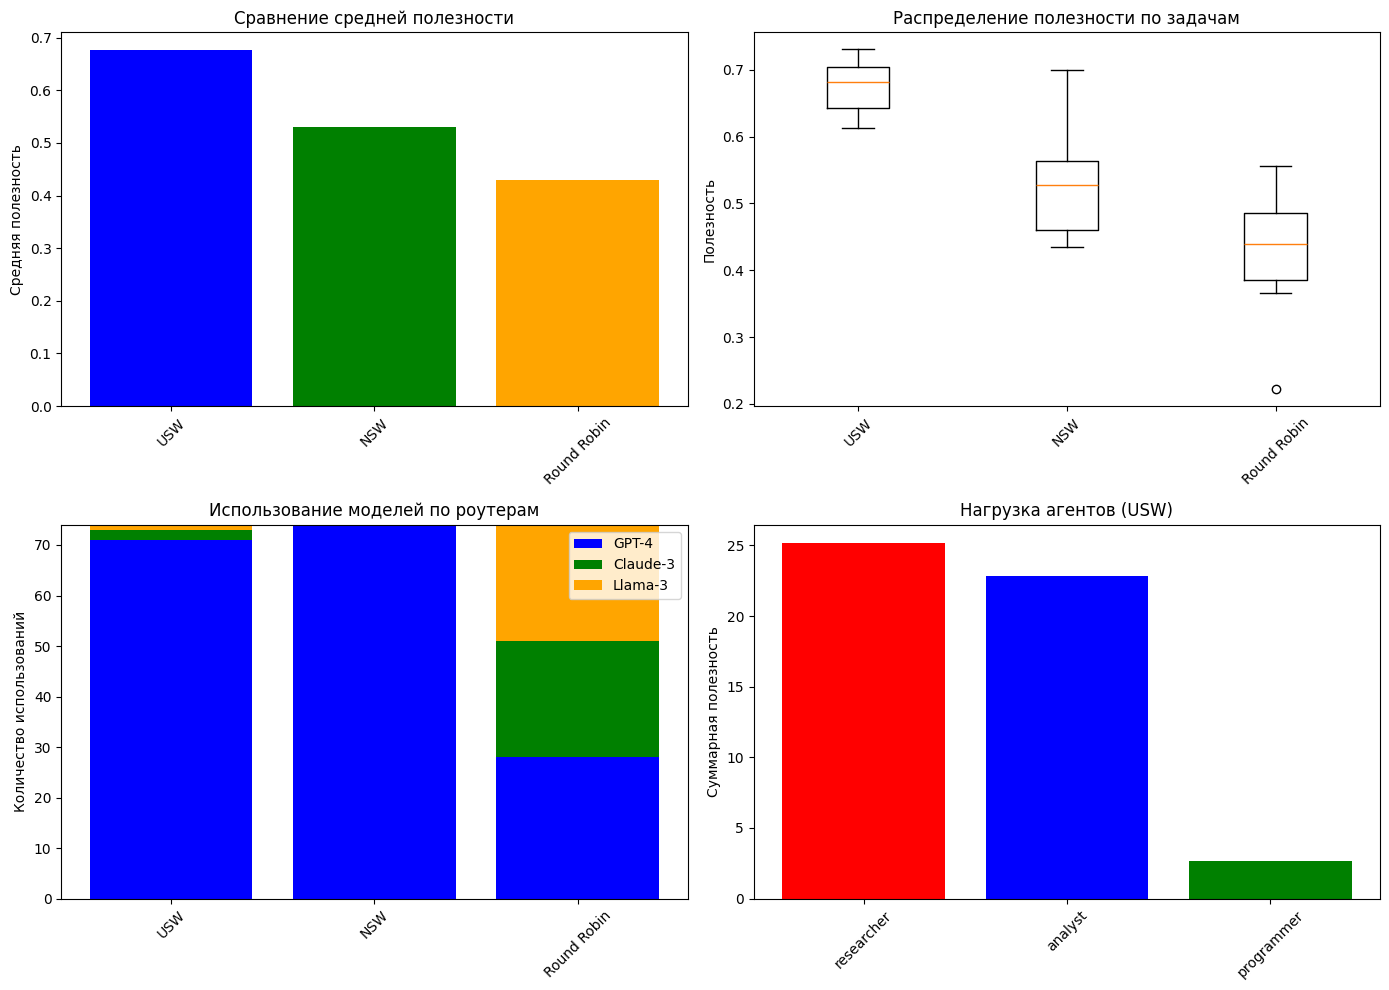


📊 СВОДНАЯ СТАТИСТИКА ПО РОУТЕРАМ

USW:
  Средняя общая полезность: 5.074 ± 2.627
  Средняя полезность на подзадачу: 0.676 ± 0.037
  Распределение моделей:
    GPT-4: 71 (95.9%)
    Claude-3: 2 (2.7%)
    Llama-3: 1 (1.4%)

NSW:
  Средняя общая полезность: 4.050 ± 2.471
  Средняя полезность на подзадачу: 0.531 ± 0.082
  Распределение моделей:
    GPT-4: 74 (100.0%)
    Claude-3: 0 (0.0%)
    Llama-3: 0 (0.0%)

Round Robin:
  Средняя общая полезность: 3.208 ± 1.684
  Средняя полезность на подзадачу: 0.430 ± 0.093
  Распределение моделей:
    GPT-4: 28 (37.8%)
    Claude-3: 23 (31.1%)
    Llama-3: 23 (31.1%)

🔍 ДЕТАЛЬНЫЙ АНАЛИЗ ПЕРВОЙ ЗАДАЧИ

Задача: c61d22de-5f6c-4958-a7f6-5e9707bd3466
Вопрос: A paper about AI regulation that was originally submitted to arXiv.org in June 2022 shows a figure w...
Уровень: 2
Подзадач: 12

  Подзадача 1:
    Тип: research
    Описание: Go to arxiv.org and navigate to the Advanced Search page....

  Подзадача 2:
    Тип: research
    Описание: Enter "AI reg

In [130]:
def main():
    """Основной скрипт тестирования"""

    print("🎯 ТЕСТИРОВАНИЕ РОУТЕРОВ НА GAIA DATASET")
    print("="*80)

    # Берем первые 10 записей
    n_tasks = 10
    gaia_subset = df.head(n_tasks).copy()

    print(f"📋 Используем первые {len(gaia_subset)} задач GAIA")
    print(f"📊 Уровни сложности: {gaia_subset['Level'].value_counts().to_dict()}")

    # Тестируем все роутеры
    results_by_router = compare_routers_on_gaia(gaia_subset, n_tasks=len(gaia_subset))

    # Визуализируем результаты
    visualize_router_comparison(results_by_router)

    # Детальный анализ первой задачи для каждого роутера
    print("\n" + "="*80)
    print("🔍 ДЕТАЛЬНЫЙ АНАЛИЗ ПЕРВОЙ ЗАДАЧИ")
    print('='*80)

    # Показываем распределение для первой задачи
    metadata = gaia_subset.iloc[0]['Annotator Metadata']
    subtasks = extract_subtasks_from_metadata(metadata, gaia_subset.iloc[0]['task_id'], 1)

    print(f"\nЗадача: {gaia_subset.iloc[0]['task_id']}")
    print(f"Вопрос: {gaia_subset.iloc[0]['Question'][:100]}...")
    print(f"Уровень: {gaia_subset.iloc[0]['Level']}")
    print(f"Подзадач: {len(subtasks)}")

    for i, subtask in enumerate(subtasks[:3]):  # Показываем первые 3
        print(f"\n  Подзадача {i+1}:")
        print(f"    Тип: {subtask.task_type.value}")
        print(f"    Описание: {subtask.description[:80]}...")

    # Генерируем utility_cube для демонстрации
    agents = [
        Agent(id="agent_researcher", role=AgentRole.RESEARCHER, tools=["web_search", "data_collection"]),
        Agent(id="agent_analyst", role=AgentRole.ANALYST, tools=["statistical_analysis", "data_interpretation"]),
        Agent(id="agent_programmer", role=AgentRole.PROGRAMMER, tools=["python", "data_visualization"])
    ]

    model_packages = [
        ModelPackage(model=LLMModel.GPT4, token_budget=2000, cost=0.001),
        ModelPackage(model=LLMModel.CLAUDE3, token_budget=3000, cost=0.001),
        ModelPackage(model=LLMModel.LLAMA3, token_budget=4000, cost=0.001)
    ]

    oracle = OptimizedOracleFixed(
        temperature=0.1,
        model_for_evaluation="gpt4",
        max_tokens_per_eval=15,
        skip_low_compatibility=True
    )

    utility_cube = oracle.generate_utility_cube_fast(
        subtasks=subtasks,
        agents=agents,
        model_packages=model_packages,
        use_llm_for=0.3
    )

    print(f"\n📊 Utility cube для первой задачи:")
    print(f"  Размер: {utility_cube.shape}")
    print(f"  Средняя полезность: {np.mean(utility_cube):.3f}")

    # Показываем лучшее распределение для каждой подзадачи
    print(f"\n🎯 Лучшие комбинации (без учета fairness):")
    for task_idx in range(min(3, len(subtasks))):  # Показываем для первых 3 подзадач
        best_agent, best_model = np.unravel_index(
            np.argmax(utility_cube[task_idx]),
            utility_cube[task_idx].shape
        )
        best_utility = utility_cube[task_idx, best_agent, best_model]

        agent_name = agents[best_agent].role.value
        model_name = model_packages[best_model].model.value

        print(f"  Подзадача {task_idx+1}: {agent_name} + {model_name} = {best_utility:.3f}")

# Запускаем тестирование
if __name__ == "__main__":
    main()

**model_for_evaluation cloud3**

🎯 ТЕСТИРОВАНИЕ РОУТЕРОВ НА GAIA DATASET
📋 Используем первые 10 задач GAIA
📊 Уровни сложности: {'2': 7, '1': 3}

🏃‍♂️ ТЕСТИРУЕМ РОУТЕР: USW

📋 Задача #1... Генерация кубика (12×3×3)
Уточнили 32 из 108 комбинаций через LLM
Стоимость: $0.0000
Оценок через LLM: 30
Размер кеша: 32
✓ Полезность: 8.630

📋 Задача #2... Генерация кубика (10×3×3)
Уточнили 27 из 90 комбинаций через LLM
Стоимость: $0.0000
Оценок через LLM: 57
Размер кеша: 59
✓ Полезность: 6.500

📋 Задача #3... Генерация кубика (3×3×3)
Уточнили 8 из 27 комбинаций через LLM
Стоимость: $0.0000
Оценок через LLM: 65
Размер кеша: 67
✓ Полезность: 1.860

📋 Задача #4... Генерация кубика (6×3×3)
Уточнили 16 из 54 комбинаций через LLM
Стоимость: $0.0000
Оценок через LLM: 81
Размер кеша: 83
✓ Полезность: 4.210

📋 Задача #5... Генерация кубика (4×3×3)
Уточнили 10 из 36 комбинаций через LLM
Стоимость: $0.0000
Оценок через LLM: 91
Размер кеша: 93
✓ Полезность: 2.720

📋 Задача #6... Генерация кубика (3×3×3)
Уточнили 8 из 27 комбинаций через LLM


/tmp/ipython-input-2963052593.py:299: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(data_for_boxplot, labels=router_names)


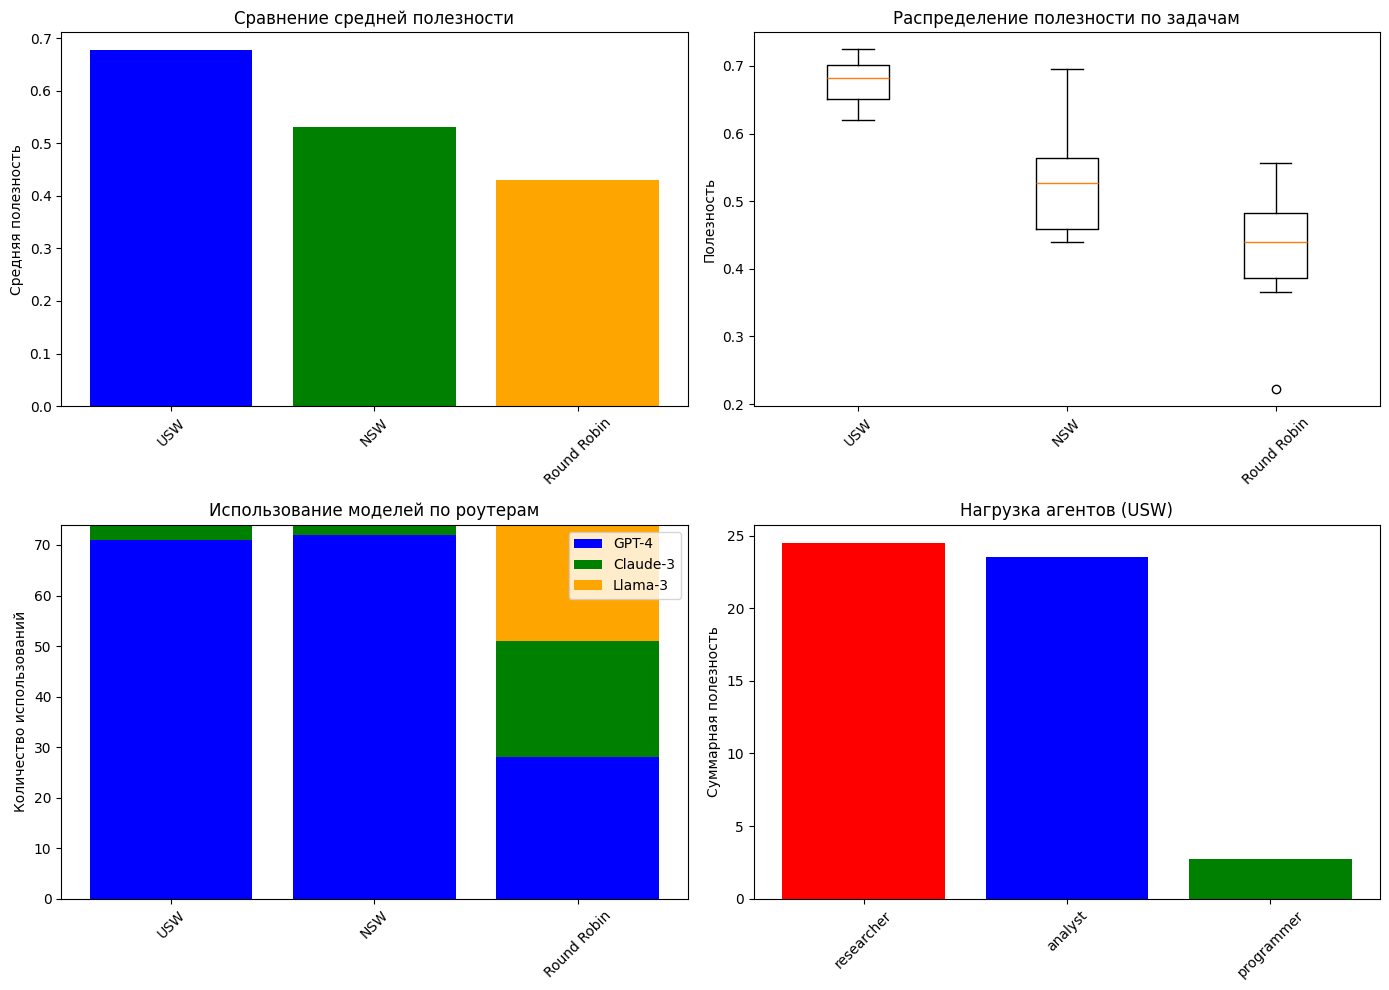


📊 СВОДНАЯ СТАТИСТИКА ПО РОУТЕРАМ

USW:
  Средняя общая полезность: 5.077 ± 2.617
  Средняя полезность на подзадачу: 0.677 ± 0.034
  Распределение моделей:
    GPT-4: 71 (95.9%)
    Claude-3: 3 (4.1%)
    Llama-3: 0 (0.0%)

NSW:
  Средняя общая полезность: 4.047 ± 2.458
  Средняя полезность на подзадачу: 0.531 ± 0.080
  Распределение моделей:
    GPT-4: 72 (97.3%)
    Claude-3: 2 (2.7%)
    Llama-3: 0 (0.0%)

Round Robin:
  Средняя общая полезность: 3.199 ± 1.671
  Средняя полезность на подзадачу: 0.430 ± 0.093
  Распределение моделей:
    GPT-4: 28 (37.8%)
    Claude-3: 23 (31.1%)
    Llama-3: 23 (31.1%)

🔍 ДЕТАЛЬНЫЙ АНАЛИЗ ПЕРВОЙ ЗАДАЧИ

Задача: c61d22de-5f6c-4958-a7f6-5e9707bd3466
Вопрос: A paper about AI regulation that was originally submitted to arXiv.org in June 2022 shows a figure w...
Уровень: 2
Подзадач: 12

  Подзадача 1:
    Тип: research
    Описание: Go to arxiv.org and navigate to the Advanced Search page....

  Подзадача 2:
    Тип: research
    Описание: Enter "AI regu

KeyError: 'cloud3'

In [131]:
def main():
    """Основной скрипт тестирования"""

    print("🎯 ТЕСТИРОВАНИЕ РОУТЕРОВ НА GAIA DATASET")
    print("="*80)

    # Берем первые 10 записей
    n_tasks = 10
    gaia_subset = df.head(n_tasks).copy()

    print(f"📋 Используем первые {len(gaia_subset)} задач GAIA")
    print(f"📊 Уровни сложности: {gaia_subset['Level'].value_counts().to_dict()}")

    # Тестируем все роутеры
    results_by_router = compare_routers_on_gaia(gaia_subset, n_tasks=len(gaia_subset))

    # Визуализируем результаты
    visualize_router_comparison(results_by_router)

    # Детальный анализ первой задачи для каждого роутера
    print("\n" + "="*80)
    print("🔍 ДЕТАЛЬНЫЙ АНАЛИЗ ПЕРВОЙ ЗАДАЧИ")
    print('='*80)

    # Показываем распределение для первой задачи
    metadata = gaia_subset.iloc[0]['Annotator Metadata']
    subtasks = extract_subtasks_from_metadata(metadata, gaia_subset.iloc[0]['task_id'], 1)

    print(f"\nЗадача: {gaia_subset.iloc[0]['task_id']}")
    print(f"Вопрос: {gaia_subset.iloc[0]['Question'][:100]}...")
    print(f"Уровень: {gaia_subset.iloc[0]['Level']}")
    print(f"Подзадач: {len(subtasks)}")

    for i, subtask in enumerate(subtasks[:3]):  # Показываем первые 3
        print(f"\n  Подзадача {i+1}:")
        print(f"    Тип: {subtask.task_type.value}")
        print(f"    Описание: {subtask.description[:80]}...")

    # Генерируем utility_cube для демонстрации
    agents = [
        Agent(id="agent_researcher", role=AgentRole.RESEARCHER, tools=["web_search", "data_collection"]),
        Agent(id="agent_analyst", role=AgentRole.ANALYST, tools=["statistical_analysis", "data_interpretation"]),
        Agent(id="agent_programmer", role=AgentRole.PROGRAMMER, tools=["python", "data_visualization"])
    ]

    model_packages = [
        ModelPackage(model=LLMModel.GPT4, token_budget=2000, cost=0.001),
        ModelPackage(model=LLMModel.CLAUDE3, token_budget=3000, cost=0.001),
        ModelPackage(model=LLMModel.LLAMA3, token_budget=4000, cost=0.001)
    ]

    oracle = OptimizedOracleFixed(
        temperature=0.1,
        model_for_evaluation="cloud3",
        max_tokens_per_eval=15,
        skip_low_compatibility=True
    )

    utility_cube = oracle.generate_utility_cube_fast(
        subtasks=subtasks,
        agents=agents,
        model_packages=model_packages,
        use_llm_for=0.3
    )

    print(f"\n📊 Utility cube для первой задачи:")
    print(f"  Размер: {utility_cube.shape}")
    print(f"  Средняя полезность: {np.mean(utility_cube):.3f}")

    # Показываем лучшее распределение для каждой подзадачи
    print(f"\n🎯 Лучшие комбинации (без учета fairness):")
    for task_idx in range(min(3, len(subtasks))):  # Показываем для первых 3 подзадач
        best_agent, best_model = np.unravel_index(
            np.argmax(utility_cube[task_idx]),
            utility_cube[task_idx].shape
        )
        best_utility = utility_cube[task_idx, best_agent, best_model]

        agent_name = agents[best_agent].role.value
        model_name = model_packages[best_model].model.value

        print(f"  Подзадача {task_idx+1}: {agent_name} + {model_name} = {best_utility:.3f}")

# Запускаем тестирование
if __name__ == "__main__":
    main()